In [1]:
from openai import OpenAI
import anthropic
from google import genai
from google.genai import types
import os

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
import plotly.express as px

from collections import Counter
from datetime import datetime, timedelta

%matplotlib inline

To choose the model, uncomment the row. Comment rows with models that are not used at the moment.

In [ ]:
# model = "gpt-4o-2024-11-20"
# model = "gpt-4.1"
# model = "o4-mini"

In [ ]:
# model = "claude-3-7-sonnet-20250219"
# model = "claude-sonnet-4-20250514"
# model = "claude-opus-4-20250514"

In [ ]:
# model = "deepseek-chat"
# model = "deepseek-reasoner"

In [ ]:
# model = "gemini-2.5-pro-preview-05-06"

In [281]:
# model = "grok-3-latest"
model = "grok-3-mini-latest"

To choose whether you want to run prompt for weigths 1 time use avg_weights = False; for 5 times use avg_weigths = True. Uncomment the necessary row, comment the unnecessary ones.

Note: running the prompt for weight assignment in the set of stocks 5 times provides more consistent results. Average weights were used in the research.

In [3]:
avg_weights = True
# avg_weights = False

## Identify sector parameters

To process the sector, uncomment the cell. Comment cells with sectors that are not processed at the moment.

In [102]:
# sector_name = 'energy'
# sector_name_full = 'Energy'
# sector_ticker = '^GSPE'
# full_ticker = 'SP500-10'

In [103]:
# sector_name = 'materials'
# sector_name_full = 'Materials'
# sector_ticker = '^SP500-15'
# full_ticker = 'SP500-15'

In [104]:
# sector_name = 'industrials'
# sector_name_full = 'Industrials'
# sector_ticker = '^SP500-20'
# full_ticker = 'SP500-20'

In [105]:
# sector_name = 'consumer_discretionary'
# sector_name_full = 'Consumer Discretionary'
# sector_ticker = '^SP500-25'
# full_ticker = 'SP500-25'

In [106]:
# sector_name = 'consumer_staples'
# sector_name_full = 'Consumer Staples'
# sector_ticker = '^SP500-30'
# full_ticker = 'SP500-30'

In [107]:
# sector_name = 'health_care'
# sector_name_full = 'Health Care'
# sector_ticker = '^SP500-35'
# full_ticker = 'SP500-35'

In [ ]:
# sector_name = 'financials'
# sector_name_full = 'Financials'
# sector_ticker = '^SP500-40'
# full_ticker = 'SP500-40'

In [ ]:
# sector_name = 'information_technology'
# sector_name_full = 'Information Technology'
# sector_ticker = '^SP500-45'
# full_ticker = 'SP500-45'

In [110]:
# sector_name = 'communication_services'
# sector_name_full = 'Communication Services'
# sector_ticker = '^SP500-50'
# full_ticker = 'SP500-50'

In [ ]:
# sector_name = 'utilities'
# sector_name_full = 'Utilities'
# sector_ticker = '^SP500-55'
# full_ticker = 'SP500-55'

In [148]:
sector_name = 'real_estate'
sector_name_full = 'Real Estate'
sector_ticker = '^SP500-60'
full_ticker = 'SP500-60'

## (Sector Ticker Check)

However, Yahoo Finance's Sector classification has some differences with GICS's classification

In [23]:
yahoo_to_gics = {
    "Communication Services": "Communication Services",
    "Consumer Cyclical": "Consumer Discretionary",
    "Consumer Defensive": "Consumer Staples",
    "Energy": "Energy",
    "Financial Services": "Financials",
    "Healthcare": "Health Care",
    "Industrials": "Industrials",
    "Basic Materials": "Materials",
    "Real Estate": "Real Estate",
    "Technology": "Information Technology",
    "Utilities": "Utilities"
}

df = pd.read_csv('SP500.csv')
df.columns = df.columns.str.replace('\xa0', ' ')
sector_companies = df['Symbol'].tolist()
sectors = []
for company in sector_companies:
    if '.' in company: company = company.replace('.', '-')
    info = yf.Ticker(company).info
    yf_sector = info.get('sector', 'Unknown')
    yf_sector = yahoo_to_gics.get(yf_sector, 'failed mapping')
    sectors.append(yf_sector)
yf_df = pd.DataFrame({
    'Symbol': sector_companies,
    'Sector': sectors
})

for i in range(503):
    if yf_df['Sector'][i] != df['GICS Sector'][i]:
        print(f"Sector mismatch for {yf_df['Symbol'][i]}: {yf_df['Sector'][i]} vs {df['GICS Sector'][i]}")


Sector mismatch for ADP: Information Technology vs Industrials
Sector mismatch for AMCR: Consumer Discretionary vs Materials
Sector mismatch for AVY: Consumer Discretionary vs Materials
Sector mismatch for BALL: Consumer Discretionary vs Materials
Sector mismatch for BR: Information Technology vs Industrials
Sector mismatch for CPAY: Information Technology vs Financials
Sector mismatch for DAY: Information Technology vs Industrials
Sector mismatch for FI: Information Technology vs Financials
Sector mismatch for FIS: Information Technology vs Financials
Sector mismatch for FTV: Information Technology vs Industrials
Sector mismatch for GPN: Industrials vs Financials
Sector mismatch for GRMN: Information Technology vs Consumer Discretionary
Sector mismatch for IP: Consumer Discretionary vs Materials
Sector mismatch for JKHY: Information Technology vs Financials
Sector mismatch for LDOS: Information Technology vs Industrials
Sector mismatch for PAYC: Information Technology vs Industrials
S

## Process data

In [149]:
sp500_df = pd.read_csv('SP500.csv')  
companies = sp500_df[sp500_df['GICS Sector'] == sector_name_full]['Symbol']
companies

30      AMT
41      ARE
43      AVB
71      BXP
79     CBRE
80      CCI
110     CPT
115    CSGP
137     DLR
139     DOC
163    EQIX
164     EQR
168     ESS
177     EXR
192     FRT
230     HST
243    INVH
248     IRM
266     KIM
295     MAA
349       O
373     PLD
384     PSA
391     REG
404    SBAC
415     SPG
458     UDR
467    VICI
475     VTR
485    WELL
494      WY
Name: Symbol, dtype: object

## Load data

In [150]:
## In-sample end date (using 5 years of weekly data prior to end date)
insample_enddate = datetime(2024, 12, 31)

## Out-of-sample period (1 Apr 2023 to 1 Dec 2023) (using daily data))
outsample_startdate = datetime(2025, 1, 1)
outsample_enddate   = datetime(2025, 6, 15)

insample_startdate = insample_enddate - timedelta(weeks=5*52) # five years prior to Jan 2025

In [151]:
# in-sample
sp500_ins = yf.download(sector_ticker, start=insample_startdate, end=insample_enddate, interval='1wk', auto_adjust = False)  ## add "auto_adjust = False"
sp500_ins['SP_Return'] = sp500_ins['Adj Close'].pct_change()

# Drop NA values in S&P 500 return data
sp500_ins.dropna(subset=[('SP_Return', '')], inplace=True) # 520 X 7 (removed first row with NaN in return)
## change subset from ['SP_Return'] to [('SP_Return', '')] for MultiIndex

# out-of-sample
sp500_outs = yf.download(sector_ticker, start=outsample_startdate, end=outsample_enddate, auto_adjust = False)  ## add auto_adjust = False
sp500_outs['SP_Return'] = sp500_outs['Adj Close'].pct_change()

# Drop NA values in S&P 500 return data
sp500_outs.dropna(subset=[('SP_Return', '')], inplace=True) # removed first row with NaN in return
## change subset from ['SP_Return'] to [('SP_Return', '')] for MultiIndex

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [152]:
insample_data_filename = f'4_returns_insample/SP500_{sector_name}_returns_till_Jan2025.csv'
outsample_data_filename = f'4_returns_outsample/SP500_{sector_name}_returns_since_Jan2025.csv'

In [153]:
if os.path.isfile(insample_data_filename):
    print("Reading data from file", insample_data_filename)
    df_returns = pd.read_csv(insample_data_filename, index_col=0)
else:
    print("Retrieving data from Yahoo Finance")
    returns = {}

    for ticker in companies:
        ticker_saved = ticker
        if '.' in ticker: ticker = ticker.replace('.', '-')
        
        try:
            df_temp = yf.download(ticker, start=insample_startdate, end=insample_enddate, interval='1wk', auto_adjust = False)

            df_temp['Return'] = df_temp['Adj Close'].pct_change()

            # removing first row because first return will be Nan
            df_temp = df_temp.iloc[1:]

            df_temp = df_temp[df_temp.index.isin(sp500_ins.index)]

            if df_temp['Return'].isna().any():
                print(f'Skipping {ticker} due to missing returns.')
                continue

            returns[ticker_saved] = df_temp['Return']

        except Exception as e:
            print(f'Failed to download {ticker} due to error: {e}')

    df_returns = pd.DataFrame(returns)
    df_returns.to_csv(insample_data_filename)

Reading data from file 4_returns_insample/SP500_real_estate_returns_till_Jan2025.csv


In [154]:
# show insample_data_file
df_returns

,AMT,ARE,AVB,BXP,CBRE,CCI,CPT,CSGP,DLR,DOC,...,PLD,PSA,REG,SBAC,SPG,UDR,VICI,VTR,WELL,WY
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-13,0.011352,0.027306,0.036556,0.033166,0.013114,0.020014,0.035304,0.006975,0.033812,0.037790,...,0.054003,0.022843,0.020672,0.029449,0.020581,0.038163,0.035475,0.032298,0.043357,0.047683
2020-01-20,0.017565,0.010804,0.015088,0.017555,-0.004260,0.032014,0.009730,0.001570,0.030698,0.020690,...,0.019943,0.016852,0.009335,0.004404,-0.019963,0.015385,0.014465,0.000340,0.006482,-0.014526
2020-01-27,-0.024335,-0.008867,-0.012036,0.009436,0.004608,-0.000400,0.012518,0.003596,-0.041088,-0.027297,...,-0.034009,-0.003163,-0.027434,-0.014181,-0.080583,-0.005604,0.005629,-0.016488,-0.023462,-0.051752
2020-02-03,0.030250,0.026655,0.011445,-0.004465,0.048812,0.004338,0.003825,0.020674,0.002358,0.008891,...,0.002799,0.006570,0.017408,0.037105,0.059107,0.019203,0.011940,0.018666,-0.009186,-0.012781
2020-02-10,0.073298,0.044046,0.038144,0.031673,-0.001093,0.102864,0.053429,0.097346,0.066678,0.027541,...,0.047348,0.033699,0.014259,0.138282,-0.014892,0.030514,0.036504,0.013743,0.061690,0.072778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-02,-0.009091,-0.057879,-0.037391,-0.020124,-0.015073,-0.041412,-0.031002,-0.049422,-0.015330,-0.027740,...,-0.040932,-0.040368,-0.019315,-0.025945,0.001307,-0.022242,-0.029439,-0.037771,-0.049283,-0.024034
2024-12-09,-0.047996,-0.011459,-0.000574,-0.005103,-0.004207,-0.046539,-0.014192,-0.029100,-0.039701,-0.028999,...,-0.007768,-0.049042,0.016727,-0.027680,-0.023063,-0.008251,-0.016430,-0.028224,-0.017127,-0.039310
2024-12-16,-0.068117,-0.033996,-0.018770,-0.066183,-0.059286,-0.051389,-0.043771,-0.048355,-0.028632,-0.030828,...,-0.070278,-0.054504,-0.020831,-0.049981,-0.033447,-0.022712,-0.075169,-0.019195,-0.034696,-0.085163


In [155]:
if os.path.isfile(outsample_data_filename):
    print("Reading data from file", outsample_data_filename)
    df_returnsOUT = pd.read_csv(outsample_data_filename, index_col=0)
else:
    print("Retrieving data from Yahoo Finance")
    returnsOS = {}

    for ticker in companies:
        ticker_saved = ticker
        if '.' in ticker: ticker = ticker.replace('.', '-')
        
        try:
            df_temp = yf.download(ticker, start=outsample_startdate, end=outsample_enddate, auto_adjust = False)

            df_temp['Return'] = df_temp['Adj Close'].pct_change()
            
            # removing first row because first return will be NaN
            df_temp = df_temp.iloc[1:]            

            df_temp = df_temp[df_temp.index.isin(sp500_outs.index)]

            # If not all dates in S&P 500 data are present in stock data, skip this stock
            if not sp500_outs.index.isin(df_temp.index).all():
                print(f'Skipping {ticker} due to mismatch in trading dates.')
                continue

            # If there are still NaN values in stock returns, skip this stock
            if df_temp['Return'].isna().any():
                print(f'Skipping {ticker} due to missing returns.')
                continue

            returnsOS[ticker_saved] = df_temp['Return']

        except Exception as e:
            print(f'Failed to download {ticker} due to error: {e}')

    df_returnsOUT = pd.DataFrame(returnsOS)
    df_returnsOUT.to_csv(outsample_data_filename)

Reading data from file 4_returns_outsample/SP500_real_estate_returns_since_Jan2025.csv


In [156]:
df_returnsOUT

,AMT,ARE,AVB,BXP,CBRE,CCI,CPT,CSGP,DLR,DOC,...,PLD,PSA,REG,SBAC,SPG,UDR,VICI,VTR,WELL,WY
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-03,0.008452,0.017026,0.009674,0.016418,0.012317,0.008178,0.020841,0.020048,0.026780,0.012897,...,0.013140,0.013049,0.011356,0.006986,0.014637,0.012932,0.016212,0.006039,0.008820,0.013219
2025-01-06,-0.012599,-0.014421,-0.029155,-0.038980,0.006768,-0.016113,-0.030836,-0.014394,-0.011775,-0.019589,...,0.009751,-0.015377,-0.026701,-0.014222,-0.009428,-0.036908,0.003394,-0.024181,-0.014068,0.004937
2025-01-07,-0.017142,-0.003786,-0.007284,-0.023059,-0.028325,-0.012198,-0.027763,-0.011937,0.001559,-0.005494,...,-0.000750,0.008011,-0.012943,-0.015282,-0.001376,-0.010123,-0.010487,0.002988,0.001532,-0.017193
2025-01-08,0.011402,0.000308,0.005397,-0.005688,0.008862,0.000457,0.006618,0.013928,0.005504,0.020593,...,-0.010133,-0.009189,-0.000143,0.019501,0.002986,0.003652,-0.014359,0.021027,0.018030,-0.011782
2025-01-10,-0.031977,-0.024643,-0.007534,-0.025454,-0.047080,-0.036228,-0.016931,-0.020605,-0.041632,-0.032480,...,-0.018104,-0.021898,-0.018817,-0.034800,-0.021352,-0.017282,-0.021505,-0.015102,-0.013441,-0.014090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-09,0.001365,0.017298,0.018558,-0.020777,0.002100,0.000707,0.014763,0.005094,-0.000905,0.000579,...,0.001287,-0.001089,0.002083,-0.003057,0.002625,0.009983,0.017477,-0.015556,-0.026805,0.010475
2025-06-10,0.008363,0.022021,0.005074,0.004271,0.031124,0.008786,0.004849,0.027243,0.005717,0.019108,...,0.005141,0.004759,0.007067,0.005200,0.002930,0.011331,0.013429,0.012769,0.003925,0.021103
2025-06-11,-0.001165,-0.001909,-0.006876,0.001235,0.007377,-0.004605,-0.005842,0.008881,-0.010411,-0.005114,...,-0.009042,-0.012697,-0.013270,-0.006235,-0.007396,-0.009058,0.000925,-0.000630,-0.004374,-0.007977


In [157]:
index_tickers = ["^GSPC", "^DJI", "^IXIC", sector_ticker]

index_data_outs = pd.DataFrame()

# Download historical data for each index for out-of-sample period
for ticker in index_tickers:
    index_df = yf.download(ticker, start=outsample_startdate, end=outsample_enddate, interval='1d', auto_adjust = False)  ##add "auto_adjust = False"
    index_df['Index_Return'] = index_df['Adj Close'].pct_change()
    index_df.dropna(subset=[('Index_Return','')], inplace=True)
    index_data_outs[ticker] = index_df['Index_Return']

index_data_outs.index = pd.to_datetime(index_data_outs.index)

valid_index_tickers_outs = []

for ticker in index_tickers:
    # Check if the ticker has continuous data in out-of-sample period
    if ticker in index_data_outs.columns and index_data_outs[ticker].notna().all():
        valid_index_tickers_outs.append(ticker)


index_tickers = valid_index_tickers_outs

print("Valid Index Tickers in Out-of-Sample Period")
print(valid_index_tickers_outs)


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Valid Index Tickers in Out-of-Sample Period
['^GSPC', '^DJI', '^IXIC', '^SP500-60']


## LLM API

### 1) ChatGPT API

In [186]:
# gpt models
with open('api_key/openai_api_key.txt', 'r', encoding='utf-8') as f:
    API_KEY = f.readline()
os.environ['OPENAI_API_KEY'] =API_KEY
client = OpenAI(
  api_key=os.environ['OPENAI_API_KEY']
) 

In [187]:
# OpenAI API parameters
max_tokens = 1024
n = 1
stop = None
temperature = 0.5

In [188]:
default_params = {
    "max_tokens": max_tokens,
    "temperature": temperature,
}

In [189]:
def generate_stocks_by_sector(sector_name, full_ticker, n_count, n_stocks, valid_tickers, recount=False):
    if model == 'gpt-4o-2024-11-20':
        csv_path = f'cached/gpt/4o_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "gpt-4.1":
        csv_path = f'cached/gpt/4.1_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "o4-mini":
        csv_path = f'cached/gpt/o4-mini_sectors/stocks15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path) and not recount:
        df = pd.read_csv(csv_path)
        print("Reading from local csv file")

        stock_counter = df.set_index('Stocks')['Count'].to_dict()
        valid_most_common_stocks = df.loc[df['IsValid'] == 1, 'Stocks'].tolist()
        
        print(stock_counter)
        print("The valid most common stocks are: ", valid_most_common_stocks)


    else:    
        prompt1 = f"Using a range of investing principles taken from leading funds, create a theoretical fund comprising of at least {n_stocks} stocks (mention their tickers) from the {full_ticker} {sector_name} sector with the goal to outperform the {full_ticker} {sector_name} sector"

        stock_counter = Counter()

        num_stocks_per_iter = []

        for i in range(n_count):
            response1 = client.chat.completions.create(
                model=model,
                messages=[
                {"role": "system", "content": "You are a helpful  assistant."},
                {"role": "user", "content": prompt1},
                ],
                n=n,
                stop=stop,
                **(default_params if model != "o4-mini" else {})
            )

            coutput1 = response1.choices[0].message.content

            prompt2 = 'Extract only the ticker symbols of the stocks comprising the fund from the previous response:- "{input}". In your response to this prompt, list only the ticker symbols separated by spaces.'.format(input=coutput1)

            response2 = client.chat.completions.create(
                model=model,
                messages=[
                {"role": "system", "content": "You are a helpful  assistant."},
                {"role": "user", "content": prompt2},
                ],
                n=n,
                stop=stop,
                **(default_params if model != "o4-mini" else {})
            )

            coutput2 = response2.choices[0].message.content

            stock_tickers = coutput2.split()

            # stock_tickers = [ticker.replace(".", "-") for ticker in stock_tickers]

            stock_tickers = ["META" if ticker == "FB" else ticker for ticker in stock_tickers]
            print(stock_tickers)

            num_stocks_per_iter.append(len(stock_tickers))
            print(num_stocks_per_iter)

            stock_counter.update(stock_tickers)
            print(stock_counter)

        average = round(np.mean(num_stocks_per_iter))

        # Get a list of all the stocks, sorted by frequency (from most to least common)
        sorted_stocks = [stock for stock, _ in stock_counter.most_common()]

        valid_tickers = set(valid_tickers)

        valid_most_common_stocks = []

        for stock in sorted_stocks:
            # If the stock is valid and we still need more stocks to reach the number 15
            if stock in valid_tickers and len(valid_most_common_stocks) < 15:
                valid_most_common_stocks.append(stock)
            elif stock not in valid_tickers:
                print(f"The stock {stock} is not in the valid list of this S&P 500 sector and hence is being discarded.")

        if len(valid_most_common_stocks) < 15:
            print("There are not enough valid stocks to reach the desired number of 15 stocks.")

        print("The valid most common stocks are: ", valid_most_common_stocks)
        
        df = pd.DataFrame.from_dict(stock_counter, orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Stocks'})
        df['IsValid'] = df['Stocks'].apply(lambda x: 1 if x in valid_most_common_stocks else 0)

        df.to_csv(csv_path, index=False)


In [190]:
generate_stocks_by_sector(sector_name, full_ticker, 10, 15, companies)
print(f'Processed  sector {sector_name}')

['PLD', 'EQIX', 'DLR', 'AMT', 'CCI', 'SBAC', 'O', 'PSA', 'VTR', 'SPG', 'VICI', 'FRT', 'AVB', 'EQR', 'UDR', 'WELL', 'SLG', 'MAA', 'HST']
[19]
Counter({'PLD': 1, 'EQIX': 1, 'DLR': 1, 'AMT': 1, 'CCI': 1, 'SBAC': 1, 'O': 1, 'PSA': 1, 'VTR': 1, 'SPG': 1, 'VICI': 1, 'FRT': 1, 'AVB': 1, 'EQR': 1, 'UDR': 1, 'WELL': 1, 'SLG': 1, 'MAA': 1, 'HST': 1})
['PLD', 'AMT', 'EQIX', 'PSA', 'CCI', 'DLR', 'SBAC', 'WELL', 'O', 'AVB', 'MAA', 'EQR', 'SUI', 'UDR', 'WPC']
[19, 15]
Counter({'PLD': 2, 'EQIX': 2, 'DLR': 2, 'AMT': 2, 'CCI': 2, 'SBAC': 2, 'O': 2, 'PSA': 2, 'AVB': 2, 'EQR': 2, 'UDR': 2, 'WELL': 2, 'MAA': 2, 'VTR': 1, 'SPG': 1, 'VICI': 1, 'FRT': 1, 'SLG': 1, 'HST': 1, 'SUI': 1, 'WPC': 1})
['AMT', 'CCI', 'EQIX', 'DLR', 'PLD', 'STAG', 'PSA', 'EXR', 'AVB', 'EQR', 'ESS', 'WELL', 'VTR', 'O', 'SPG', 'VICI', 'HST']
[19, 15, 17]
Counter({'PLD': 3, 'EQIX': 3, 'DLR': 3, 'AMT': 3, 'CCI': 3, 'O': 3, 'PSA': 3, 'AVB': 3, 'EQR': 3, 'WELL': 3, 'SBAC': 2, 'VTR': 2, 'SPG': 2, 'VICI': 2, 'UDR': 2, 'MAA': 2, 'HST': 2, 'FR

### 2) Claude API

In [233]:
with open('api_key/anthropic_api_key.txt', 'r', encoding='utf-8') as f:
    API_KEY = f.readline()
os.environ['ANTHROPIC_API_KEY'] = API_KEY
client = anthropic.Anthropic(
  api_key=os.environ['ANTHROPIC_API_KEY']
)

In [234]:
# Anthropic API parameters
max_tokens = 1024
temperature = 0.5

In [235]:
def generate_stocks_by_sector_claude(sector_name, full_ticker, n_count, n_stocks, valid_tickers, recount=False):
    if model == "claude-3-7-sonnet-20250219":
        csv_path = f'cached/claude/sonnet-3.7_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "claude-sonnet-4-20250514":
        csv_path = f'cached/claude/sonnet-4_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "claude-opus-4-20250514":
        csv_path = f'cached/claude/opus-4_sectors/stocks15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path) and not recount:
        df = pd.read_csv(csv_path)
        print("Reading from local csv file")

        stock_counter = df.set_index('Stocks')['Count'].to_dict()
        valid_most_common_stocks = df.loc[df['IsValid'] == 1, 'Stocks'].tolist()
        
        print(stock_counter)
        print("The valid most common stocks are: ", valid_most_common_stocks)


    else:    
        prompt1 = f"Using a range of investing principles taken from leading funds, create a theoretical fund comprising of at least {n_stocks} stocks (mention their tickers) from the {full_ticker} {sector_name} sector with the goal to outperform the {full_ticker} {sector_name} sector (S&P 500 sector index)"

        stock_counter = Counter()

        num_stocks_per_iter = []

        for i in range(n_count):
            response1 = client.messages.create(
                model=model,
                system = "You are a helpful  assistant.",
                messages=[
                {"role": "user", "content": prompt1},
                ],
                max_tokens=max_tokens,
                temperature=temperature,
            )

            coutput1 = response1.content[0].text

            prompt2 = 'Extract only the ticker symbols of the stocks comprising the fund from the previous response:- "{input}". In your response to this prompt, list only the ticker symbols separated by spaces.'.format(input=coutput1)

            response2 = client.messages.create(
                model=model,
                system = "You are a helpful  assistant.",
                messages=[
                {"role": "user", "content": prompt2},
                ],
                max_tokens=max_tokens,
                temperature=temperature,
            )

            coutput2 = response2.content[0].text

            stock_tickers = coutput2.split()

            # stock_tickers = [ticker.replace(".", "-") for ticker in stock_tickers]

            stock_tickers = ["META" if ticker == "FB" else ticker for ticker in stock_tickers]
            print(stock_tickers)

            num_stocks_per_iter.append(len(stock_tickers))
            print(num_stocks_per_iter)

            stock_counter.update(stock_tickers)
            print(stock_counter)

        average = round(np.mean(num_stocks_per_iter))

        # Get a list of all the stocks, sorted by frequency (from most to least common)
        sorted_stocks = [stock for stock, _ in stock_counter.most_common()]

        valid_tickers = set(valid_tickers)

        valid_most_common_stocks = []

        for stock in sorted_stocks:
            # If the stock is valid and we still need more stocks to reach the number 15
            if stock in valid_tickers and len(valid_most_common_stocks) < 15:
                valid_most_common_stocks.append(stock)
            elif stock not in valid_tickers:
                print(f"The stock {stock} is not in the valid list of this S&P 500 sector and hence is being discarded.")

        if len(valid_most_common_stocks) < 15:
            print("There are not enough valid stocks to reach the desired number of 15 stocks.")

        print("The valid most common stocks are: ", valid_most_common_stocks)
        
        df = pd.DataFrame.from_dict(stock_counter, orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Stocks'})
        df['IsValid'] = df['Stocks'].apply(lambda x: 1 if x in valid_most_common_stocks else 0)

        df.to_csv(csv_path, index=False)


In [236]:
generate_stocks_by_sector_claude(sector_name, full_ticker, 10, 15, companies)
print(f'Processed  sector {sector_name}')

['PLD', 'EQIX', 'AMT', 'PSA', 'DLR', 'SBAC', 'EXR', 'INVH', 'SPG', 'VTR', 'KIM', 'O', 'WPC', 'STAG']
[14]
Counter({'PLD': 1, 'EQIX': 1, 'AMT': 1, 'PSA': 1, 'DLR': 1, 'SBAC': 1, 'EXR': 1, 'INVH': 1, 'SPG': 1, 'VTR': 1, 'KIM': 1, 'O': 1, 'WPC': 1, 'STAG': 1})
['PLD', 'EQIX', 'AMT', 'SPG', 'DLR', 'WELL', 'EQR', 'REXR', 'VTR', 'KIM', 'BXP', 'PSA', 'SBAC', 'IRM', 'LAMR']
[14, 15]
Counter({'PLD': 2, 'EQIX': 2, 'AMT': 2, 'PSA': 2, 'DLR': 2, 'SBAC': 2, 'SPG': 2, 'VTR': 2, 'KIM': 2, 'EXR': 1, 'INVH': 1, 'O': 1, 'WPC': 1, 'STAG': 1, 'WELL': 1, 'EQR': 1, 'REXR': 1, 'BXP': 1, 'IRM': 1, 'LAMR': 1})
['PLD', 'AMT', 'EQIX', 'SPG', 'WELL', 'EQR', 'PSA', 'INVH', 'DLR', 'VTR', 'O', 'BXP', 'ARE', 'ESS', 'AVB']
[14, 15, 15]
Counter({'PLD': 3, 'EQIX': 3, 'AMT': 3, 'PSA': 3, 'DLR': 3, 'SPG': 3, 'VTR': 3, 'SBAC': 2, 'INVH': 2, 'KIM': 2, 'O': 2, 'WELL': 2, 'EQR': 2, 'BXP': 2, 'EXR': 1, 'WPC': 1, 'STAG': 1, 'REXR': 1, 'IRM': 1, 'LAMR': 1, 'ARE': 1, 'ESS': 1, 'AVB': 1})
['PLD', 'AMT', 'EQIX', 'PSA', 'DLR', 'SBAC

### 3) Deepseek API

In [311]:
with open('api_key/deepseek_api_key.txt', 'r', encoding='utf-8') as f:
    API_KEY = f.readline()
os.environ['DEEPSEEK_API_KEY'] = API_KEY
client = OpenAI(
  api_key=os.environ['DEEPSEEK_API_KEY'],
  base_url="https://api.deepseek.com"
)

In [312]:
# DEEPSEEK API parameters
max_tokens = 1024
n = 1
stop = None
temperature = 0.5

In [313]:
default_params_ds = {
    "max_tokens": max_tokens,
    "temperature": temperature,
}

In [314]:
def generate_stocks_by_sector_deepseek(sector_name, full_ticker, n_count, n_stocks, valid_tickers, recount=False):
    if model == 'deepseek-chat':
        csv_path = f'cached/ds/dsV3_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "deepseek-reasoner":
        csv_path = f'cached/ds/dsR1_sectors/stocks15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path) and not recount:
        df = pd.read_csv(csv_path)
        print("Reading from local csv file")

        stock_counter = df.set_index('Stocks')['Count'].to_dict()
        valid_most_common_stocks = df.loc[df['IsValid'] == 1, 'Stocks'].tolist()
        
        print(stock_counter)
        print("The valid most common stocks are: ", valid_most_common_stocks)


    else:    
        prompt1 = f"Using a range of investing principles taken from leading funds, create a theoretical fund comprising of at least {n_stocks} stocks (mention their tickers) from the {full_ticker} {sector_name} sector with the goal to outperform the {full_ticker} {sector_name} sector"

        stock_counter = Counter()

        num_stocks_per_iter = []

        for i in range(n_count):
            response1 = client.chat.completions.create(
                model=model,
                messages=[
                {"role": "system", "content": "You are a helpful  assistant."},
                {"role": "user", "content": prompt1},
                ],
                n = n,
                stop = stop,
                **(default_params_ds if model != "deepseek-reasoner" else {})
            )

            coutput1 = response1.choices[0].message.content

            prompt2 = 'Extract only the ticker symbols of the stocks comprising the fund from the previous response:- "{input}". In your response to this prompt, list only the ticker symbols separated by spaces.'.format(input=coutput1)

            response2 = client.chat.completions.create(
                model=model,
                messages=[
                {"role": "system", "content": "You are a helpful  assistant."},
                {"role": "user", "content": prompt2},
                ],
                n = n,
                stop = stop,
                **(default_params_ds if model != "deepseek-reasoner" else {})
            )

            coutput2 = response2.choices[0].message.content

            stock_tickers = coutput2.split()

            # stock_tickers = [ticker.replace(".", "-") for ticker in stock_tickers]

            stock_tickers = ["META" if ticker == "FB" else ticker for ticker in stock_tickers]
            print(stock_tickers)

            num_stocks_per_iter.append(len(stock_tickers))
            print(num_stocks_per_iter)

            stock_counter.update(stock_tickers)
            print(stock_counter)

        average = round(np.mean(num_stocks_per_iter))

        # Get a list of all the stocks, sorted by frequency (from most to least common)
        sorted_stocks = [stock for stock, _ in stock_counter.most_common()]

        valid_tickers = set(valid_tickers)

        valid_most_common_stocks = []

        for stock in sorted_stocks:
            # If the stock is valid and we still need more stocks to reach the number 15
            if stock in valid_tickers and len(valid_most_common_stocks) < 15:
                valid_most_common_stocks.append(stock)
            elif stock not in valid_tickers:
                print(f"The stock {stock} is not in the valid list of this S&P 500 sector and hence is being discarded.")

        if len(valid_most_common_stocks) < 15:
            print("There are not enough valid stocks to reach the desired number of 15 stocks.")

        print("The valid most common stocks are: ", valid_most_common_stocks)
        
        df = pd.DataFrame.from_dict(stock_counter, orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Stocks'})
        df['IsValid'] = df['Stocks'].apply(lambda x: 1 if x in valid_most_common_stocks else 0)

        df.to_csv(csv_path, index=False)


In [315]:
generate_stocks_by_sector_deepseek(sector_name, full_ticker, 10, 15, companies)
print(f'Processed  sector {sector_name}')

['AMT', 'PLD', 'EQIX', 'AVB', 'EQR', 'DLR', 'PSA', 'O', 'SPG', 'VTR', 'WELL', 'ESS', 'IRM', 'CBRE', 'INVH']
[15]
Counter({'AMT': 1, 'PLD': 1, 'EQIX': 1, 'AVB': 1, 'EQR': 1, 'DLR': 1, 'PSA': 1, 'O': 1, 'SPG': 1, 'VTR': 1, 'WELL': 1, 'ESS': 1, 'IRM': 1, 'CBRE': 1, 'INVH': 1})
['AMT', 'PLD', 'EQIX', 'CCI', 'SBAC', 'AVB', 'EQR', 'ESS', 'O', 'SPG', 'DLR', 'WELL', 'VTR', 'PSA', 'EXR']
[15, 15]
Counter({'AMT': 2, 'PLD': 2, 'EQIX': 2, 'AVB': 2, 'EQR': 2, 'DLR': 2, 'PSA': 2, 'O': 2, 'SPG': 2, 'VTR': 2, 'WELL': 2, 'ESS': 2, 'IRM': 1, 'CBRE': 1, 'INVH': 1, 'CCI': 1, 'SBAC': 1, 'EXR': 1})
['PLD', 'EQIX', 'AMT', 'SPG', 'PSA', 'DLR', 'AVB', 'EXR', 'SBAC', 'INVH', 'VNO', 'BXP', 'O', 'WELL', 'WPC']
[15, 15, 15]
Counter({'AMT': 3, 'PLD': 3, 'EQIX': 3, 'AVB': 3, 'DLR': 3, 'PSA': 3, 'O': 3, 'SPG': 3, 'WELL': 3, 'EQR': 2, 'VTR': 2, 'ESS': 2, 'INVH': 2, 'SBAC': 2, 'EXR': 2, 'IRM': 1, 'CBRE': 1, 'CCI': 1, 'VNO': 1, 'BXP': 1, 'WPC': 1})
['PLD', 'AMT', 'EQIX', 'AVB', 'ESS', 'O', 'SPG', 'DLR', 'WELL', 'SBAC', 

### 4) Gemini API

In [253]:
with open('api_key/gemini_api_key.txt', 'r', encoding='utf-8') as f: ## current one is the test one
    API_KEY = f.readline()
os.environ['GEMINI_API_KEY'] = API_KEY
client = genai.Client(
  api_key=os.environ['GEMINI_API_KEY']
)

In [254]:
# Gemini API parameters 
max_output_tokens = 1024
stop_sequences = None
temperature = 0.5

In [255]:
def generate_stocks_by_sector_gemini(sector_name, full_ticker, n_count, n_stocks, valid_tickers, recount=False):
    if model == 'gemini-2.5-pro-preview-05-06':
        csv_path = f'cached/gemini/gemini_sectors/stocks15_auto_{sector_name}.csv'
    

    if os.path.isfile(csv_path) and not recount:
        df = pd.read_csv(csv_path)
        print("Reading from local csv file")

        stock_counter = df.set_index('Stocks')['Count'].to_dict()
        valid_most_common_stocks = df.loc[df['IsValid'] == 1, 'Stocks'].tolist()
        
        print(stock_counter)
        print("The valid most common stocks are: ", valid_most_common_stocks)


    else:    
        prompt1 = f"Using a range of investing principles taken from leading funds, create a theoretical fund comprising of at least {n_stocks} stocks (mention their tickers) from the {full_ticker} {sector_name} sector with the goal to outperform the {full_ticker} {sector_name} sector"

        stock_counter = Counter()

        num_stocks_per_iter = []

        for i in range(n_count):
            response1 = client.models.generate_content(
                model=model,
                contents=[prompt1],
                config=types.GenerateContentConfig(
                    system_instruction="You are a helpful  assistant.",
                    ##max_output_tokens=max_output_tokens,
                    ##stop_sequences=stop_sequences,
                    temperature=temperature
                )
            )

            coutput1 = response1.text

            prompt2 = 'Extract only the ticker symbols of the stocks comprising the fund from the previous response:- "{input}". In your response to this prompt, list only the ticker symbols separated by spaces.'.format(input=coutput1)

            response2 = client.models.generate_content(
                model=model,
                contents=[prompt2],
                config=types.GenerateContentConfig(
                    system_instruction="You are a helpful  assistant.",
                    ##max_output_tokens=max_output_tokens,
                    ##stop_sequences=stop_sequences,
                    temperature=temperature
                )
            )

            coutput2 = response2.text

            stock_tickers = coutput2.split()

            # stock_tickers = [ticker.replace(".", "-") for ticker in stock_tickers]

            stock_tickers = ["META" if ticker == "FB" else ticker for ticker in stock_tickers]
            print(stock_tickers)

            num_stocks_per_iter.append(len(stock_tickers))
            print(num_stocks_per_iter)

            stock_counter.update(stock_tickers)
            print(stock_counter)

        average = round(np.mean(num_stocks_per_iter))

        # Get a list of all the stocks, sorted by frequency (from most to least common)
        sorted_stocks = [stock for stock, _ in stock_counter.most_common()]

        valid_tickers = set(valid_tickers)

        valid_most_common_stocks = []

        for stock in sorted_stocks:
            # If the stock is valid and we still need more stocks to reach the number 15
            if stock in valid_tickers and len(valid_most_common_stocks) < 15:
                valid_most_common_stocks.append(stock)
            elif stock not in valid_tickers:
                print(f"The stock {stock} is not in the valid list of this S&P 500 sector and hence is being discarded.")

        if len(valid_most_common_stocks) < 15:
            print("There are not enough valid stocks to reach the desired number of 15 stocks.")

        print("The valid most common stocks are: ", valid_most_common_stocks)
        
        df = pd.DataFrame.from_dict(stock_counter, orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Stocks'})
        df['IsValid'] = df['Stocks'].apply(lambda x: 1 if x in valid_most_common_stocks else 0)

        df.to_csv(csv_path, index=False)


In [256]:
generate_stocks_by_sector_gemini(sector_name, full_ticker, 10, 15, companies)
print(f'Processed  sector {sector_name}')

['PLD', 'PSA', 'O', 'AVB', 'EQR', 'SPG', 'WELL', 'AMT', 'EQIX', 'CCI', 'DLR', 'ARE', 'REXR', 'BXP', 'VICI', 'KIM']
[16]
Counter({'PLD': 1, 'PSA': 1, 'O': 1, 'AVB': 1, 'EQR': 1, 'SPG': 1, 'WELL': 1, 'AMT': 1, 'EQIX': 1, 'CCI': 1, 'DLR': 1, 'ARE': 1, 'REXR': 1, 'BXP': 1, 'VICI': 1, 'KIM': 1})
['PLD', 'EQIX', 'AMT', 'PSA', 'O', 'AVB', 'WELL', 'SPG', 'CCI', 'DLR', 'SBAC', 'VICI', 'BXP', 'KIM', 'WY', 'EXR']
[16, 16]
Counter({'PLD': 2, 'PSA': 2, 'O': 2, 'AVB': 2, 'SPG': 2, 'WELL': 2, 'AMT': 2, 'EQIX': 2, 'CCI': 2, 'DLR': 2, 'BXP': 2, 'VICI': 2, 'KIM': 2, 'EQR': 1, 'ARE': 1, 'REXR': 1, 'SBAC': 1, 'WY': 1, 'EXR': 1})
['PLD', 'REXR', 'EGP', 'EQIX', 'DLR', 'AMT', 'CCI', 'AVB', 'MAA', 'EQR', 'PSA', 'WELL', 'VICI', 'O', 'WY', 'IRM']
[16, 16, 16]
Counter({'PLD': 3, 'PSA': 3, 'O': 3, 'AVB': 3, 'WELL': 3, 'AMT': 3, 'EQIX': 3, 'CCI': 3, 'DLR': 3, 'VICI': 3, 'EQR': 2, 'SPG': 2, 'REXR': 2, 'BXP': 2, 'KIM': 2, 'WY': 2, 'ARE': 1, 'SBAC': 1, 'EXR': 1, 'EGP': 1, 'MAA': 1, 'IRM': 1})
['AMT', 'EQIX', 'CCI', '

### 5) Grok API

In [282]:
with open('api_key/grok_api_key.txt', 'r', encoding='utf-8') as f:  ## this one is the test one
    API_KEY = f.readline()
os.environ['GROK_API_KEY'] = API_KEY
client = OpenAI(
  api_key=os.environ['GROK_API_KEY'],
  base_url="https://api.x.ai/v1",
)

In [283]:
# Grok API parameters
max_tokens = 1024
n = 1
stop = None
temperature = 0.5
reasoning_effort = "high"

In [284]:
default_params_x = {
    "reasoning_effort": reasoning_effort
}

In [285]:
def generate_stocks_by_sector_grok(sector_name, full_ticker, n_count, n_stocks, valid_tickers, recount=False):
    if model == 'grok-3-latest':
        csv_path = f'cached/grok/grok3_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "grok-3-mini-latest":
        csv_path = f'cached/grok/grok3-mini_sectors/stocks15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path) and not recount:
        df = pd.read_csv(csv_path)
        print("Reading from local csv file")

        stock_counter = df.set_index('Stocks')['Count'].to_dict()
        valid_most_common_stocks = df.loc[df['IsValid'] == 1, 'Stocks'].tolist()
        
        print(stock_counter)
        print("The valid most common stocks are: ", valid_most_common_stocks)


    else:    
        prompt1 = f"Using a range of investing principles taken from leading funds, create a theoretical fund comprising of at least {n_stocks} stocks (mention their tickers) from the {full_ticker} {sector_name} sector with the goal to outperform the {full_ticker} {sector_name} sector"

        stock_counter = Counter()

        num_stocks_per_iter = []

        for i in range(n_count):
            response1 = client.chat.completions.create(
                model=model,
                messages=[
                {"role": "system", "content": "You are a helpful  assistant."},
                {"role": "user", "content": prompt1},
                ],
                ##max_tokens=max_tokens,
                n=n,
                stop=stop,
                temperature=temperature,
                **(default_params_x if model == "grok-3-mini-latest" else {})
            )

            coutput1 = response1.choices[0].message.content

            prompt2 = 'Extract only the ticker symbols of the stocks comprising the fund from the previous response:- "{input}". In your response to this prompt, list only the ticker symbols separated by spaces.'.format(input=coutput1)

            response2 = client.chat.completions.create(
                model=model,
                messages=[
                {"role": "system", "content": "You are a helpful  assistant."},
                {"role": "user", "content": prompt2},
                ],
                ##max_tokens=max_tokens,
                n=n,
                stop=stop,
                temperature=temperature,
                **(default_params_x if model == "grok-3-mini-latest" else {})
            )

            coutput2 = response2.choices[0].message.content

            stock_tickers = coutput2.split()

            # stock_tickers = [ticker.replace(".", "-") for ticker in stock_tickers]

            stock_tickers = ["META" if ticker == "FB" else ticker for ticker in stock_tickers]
            print(stock_tickers)

            num_stocks_per_iter.append(len(stock_tickers))
            print(num_stocks_per_iter)

            stock_counter.update(stock_tickers)
            print(stock_counter)

        average = round(np.mean(num_stocks_per_iter))

        # Get a list of all the stocks, sorted by frequency (from most to least common)
        sorted_stocks = [stock for stock, _ in stock_counter.most_common()]

        valid_tickers = set(valid_tickers)

        valid_most_common_stocks = []

        for stock in sorted_stocks:
            # If the stock is valid and we still need more stocks to reach the number 15
            if stock in valid_tickers and len(valid_most_common_stocks) < 15:
                valid_most_common_stocks.append(stock)
            elif stock not in valid_tickers:
                print(f"The stock {stock} is not in the valid list of this S&P 500 sector and hence is being discarded.")

        if len(valid_most_common_stocks) < 15:
            print("There are not enough valid stocks to reach the desired number of 15 stocks.")

        print("The valid most common stocks are: ", valid_most_common_stocks)
        
        df = pd.DataFrame.from_dict(stock_counter, orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Stocks'})
        df['IsValid'] = df['Stocks'].apply(lambda x: 1 if x in valid_most_common_stocks else 0)

        df.to_csv(csv_path, index=False)


In [286]:
generate_stocks_by_sector_grok(sector_name, full_ticker, 10, 15, companies)
print(f'Processed  sector {sector_name}')

['AMT', 'EQIX', 'PSA', 'O', 'DLR', 'AVB', 'EQR', 'SPG', 'ARE', 'BXP', 'WY', 'IRM', 'KIM', 'HST', 'PEAK']
[15]
Counter({'AMT': 1, 'EQIX': 1, 'PSA': 1, 'O': 1, 'DLR': 1, 'AVB': 1, 'EQR': 1, 'SPG': 1, 'ARE': 1, 'BXP': 1, 'WY': 1, 'IRM': 1, 'KIM': 1, 'HST': 1, 'PEAK': 1})
['EQIX', 'DLR', 'PLD', 'AMT', 'O', 'PSA', 'SPG', 'AVB', 'EQR', 'WELL', 'ARE', 'VTR', 'EXR', 'BXP', 'HST']
[15, 15]
Counter({'AMT': 2, 'EQIX': 2, 'PSA': 2, 'O': 2, 'DLR': 2, 'AVB': 2, 'EQR': 2, 'SPG': 2, 'ARE': 2, 'BXP': 2, 'HST': 2, 'WY': 1, 'IRM': 1, 'KIM': 1, 'PEAK': 1, 'PLD': 1, 'WELL': 1, 'VTR': 1, 'EXR': 1})
['AMT', 'PLD', 'EQIX', 'SPG', 'PSA', 'O', 'DLR', 'WELL', 'AVB', 'EQR', 'EXR', 'BXP', 'VICI', 'HST', 'IRM']
[15, 15, 15]
Counter({'AMT': 3, 'EQIX': 3, 'PSA': 3, 'O': 3, 'DLR': 3, 'AVB': 3, 'EQR': 3, 'SPG': 3, 'BXP': 3, 'HST': 3, 'ARE': 2, 'IRM': 2, 'PLD': 2, 'WELL': 2, 'EXR': 2, 'WY': 1, 'KIM': 1, 'PEAK': 1, 'VTR': 1, 'VICI': 1})
['PLD', 'EQIX', 'AMT', 'DLR', 'O', 'WELL', 'AVB', 'EQR', 'PSA', 'CCI', 'EXR', 'VICI',

## Count stocks outside of sector

In [287]:
# gpt models
if model == 'gpt-4o-2024-11-20':
    csv_path = f'cached/gpt/4o_sectors/stocks15_auto_{sector_name}.csv'
elif model == "gpt-4.1":
    csv_path = f'cached/gpt/4.1_sectors/stocks15_auto_{sector_name}.csv'
elif model == "o4-mini":
    csv_path = f'cached/gpt/o4-mini_sectors/stocks15_auto_{sector_name}.csv'
# claude model
elif model == "claude-3-7-sonnet-20250219":
    csv_path = f'cached/claude/sonnet-3.7_sectors/stocks15_auto_{sector_name}.csv'
elif model == "claude-sonnet-4-20250514":
    csv_path = f'cached/claude/sonnet-4_sectors/stocks15_auto_{sector_name}.csv'
elif model == "claude-opus-4-20250514":
    csv_path = f'cached/claude/opus-4_sectors/stocks15_auto_{sector_name}.csv'
# deepseek models
elif model == 'deepseek-chat':
    csv_path = f'cached/ds/dsV3_sectors/stocks15_auto_{sector_name}.csv'
elif model == "deepseek-reasoner":
    csv_path = f'cached/ds/dsR1_sectors/stocks15_auto_{sector_name}.csv'
# gemini model
elif model == 'gemini-2.5-pro-preview-05-06':
        csv_path = f'cached/gemini/gemini_sectors/stocks15_auto_{sector_name}.csv'
# grok models
elif model == 'grok-3-latest':
    csv_path = f'cached/grok/grok3_sectors/stocks15_auto_{sector_name}.csv'
elif model == "grok-3-mini-latest":
    csv_path = f'cached/grok/grok3-mini_sectors/stocks15_auto_{sector_name}.csv'


df_count = pd.read_csv(csv_path)

counter_invalid = 0
for stock in df_count['Stocks']:
    ##print(stock)
    if not (stock in list(companies)):
        counter_invalid += 1
        print(stock)

print(counter_invalid)

PEAK
VNO
CUBE
ELS
4


## Count stocks

In [20]:
SMALL2_SIZE = 6
SMALL1_SIZE = 7
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('xtick', labelsize=SMALL_SIZE)

In [21]:
def plot_selected_by_sector(sector):
    # gpt models
    if model == 'gpt-4o-2024-11-20':
        csv_path = f'cached/gpt/4o_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "gpt-4.1":
        csv_path = f'cached/gpt/4.1_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "o4-mini":
        csv_path = f'cached/gpt/o4-mini_sectors/stocks15_auto_{sector_name}.csv'
    # claude model
    elif model == "claude-3-7-sonnet-20250219":
        csv_path = f'cached/claude/sonnet-3.7_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "claude-sonnet-4-20250514":
        csv_path = f'cached/claude/sonnet-4_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "claude-opus-4-20250514":
        csv_path = f'cached/claude/opus-4_sectors/stocks15_auto_{sector_name}.csv'
    # deepseek models
    elif model == 'deepseek-chat':
        csv_path = f'cached/ds/dsV3_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "deepseek-reasoner":
        csv_path = f'cached/ds/dsR1_sectors/stocks15_auto_{sector_name}.csv'
    # gemini model
    elif model == 'gemini-2.5-pro-preview-05-06':
        csv_path = f'cached/gemini/gemini_sectors/stocks15_auto_{sector_name}.csv'
    # grok models
    elif model == 'grok-3-latest':
        csv_path = f'cached/grok/grok3_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "grok-3-mini-latest":
        csv_path = f'cached/grok/grok3-mini_sectors/stocks15_auto_{sector_name}.csv'

    temp_df = pd.read_csv(csv_path)
    temp_df = temp_df.sort_values(by='IsValid', ascending=False)

    stock_counter = temp_df.set_index('Stocks')['Count'].to_dict()
    print('Number of stocks in the universe before selecting 15: ', len(stock_counter))
    valid_most_common_stocks = temp_df.loc[temp_df['IsValid'] == 1, 'Stocks'].tolist()

    plt.figure(figsize=(10, 6))

    ##modification start
    green_stocks, orange_stocks, gray_stocks = [], [], []
    for ticker, count in stock_counter.items():
        if ticker not in list(companies):
            gray_stocks.append((ticker, count))
        elif ticker in valid_most_common_stocks:
            green_stocks.append((ticker, count))
        else:
            orange_stocks.append((ticker, count))

    green_stocks.sort(key=lambda x: x[1], reverse=True)
    orange_stocks.sort(key=lambda x: x[1], reverse=True)
    gray_stocks.sort(key=lambda x: x[1], reverse=True)

    sorted_stocks = green_stocks + orange_stocks + gray_stocks
    tickers, counts = zip(*sorted_stocks)
    colors = ['green'] * len(green_stocks) + ['orange'] * len(orange_stocks) + ['gray'] * len(gray_stocks)
    ##modification end

    ##tickers, counts = zip(*stock_counter.items())
    ##colors = ['green' if ticker in valid_most_common_stocks else 'orange' for ticker in tickers]

    k_value_case1 = len(valid_most_common_stocks)

    plt.bar(tickers, counts, color=colors)
    plt.xlabel('Stock tickers')
    plt.ylabel('Number of occurrences')
    plt.xticks(rotation=90)
    plt.tight_layout()
    # plt.savefig('GPT_'+str(k_value_case1)+'_instr_universe.eps', format='eps', dpi=1200)
    # plt.savefig('GPT_'+str(k_value_case1)+'_instr_universe.png', format='png', dpi=600)
    plt.title(f'Selected stocks in {sector_name_full} sector ({model})')

    green_patch = mpatches.Patch(color='green', label='Valid most frequent stocks')
    orange_patch = mpatches.Patch(color='orange', label='Non-frequent stocks')
    gray_patch = mpatches.Patch(color='gray', label='Stocks outside of sector index')

    plt.legend(handles=[green_patch, orange_patch, gray_patch], 
            loc='upper right')

    plt.show()

    print(f'Processed {sector} sector')

GREY means stocks that are not not valid

Number of stocks in the universe before selecting 15:  28


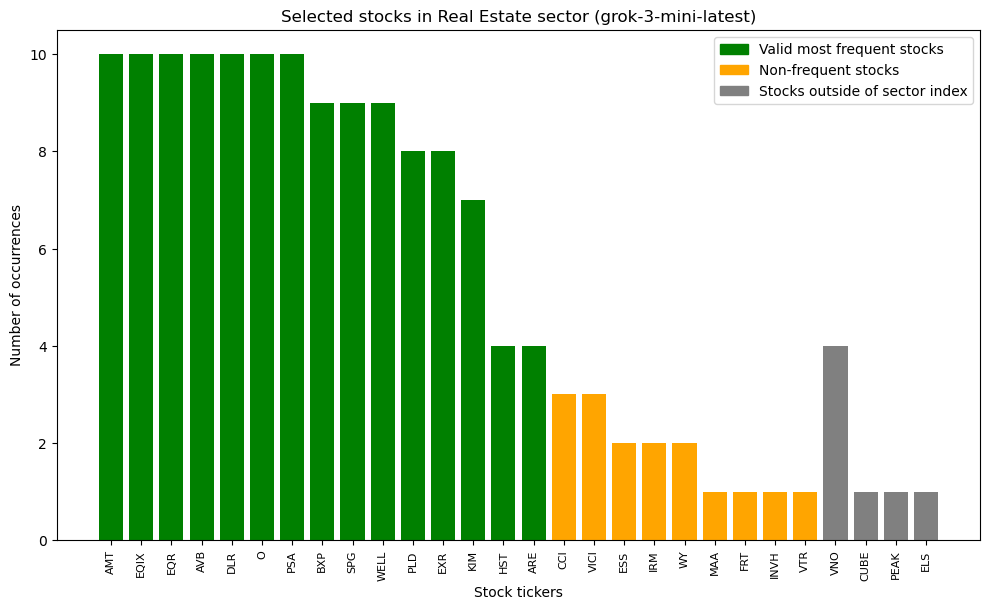

Processed real_estate sector


In [288]:
plot_selected_by_sector(sector_name)

## Weighted portfolio

In [23]:
def convert_reponse4_to_df(coutput4):
    df = pd.DataFrame()
    pairs = coutput4.split(',')
    stocks, weights = [], []

    for pair in pairs:
        stock, weight = pair.split(':')
        stocks.append(stock)
        weights.append(float(weight))

    df = pd.DataFrame({'Stock': stocks, 'Weight': weights})

    if not np.isclose(df['Weight'].sum(), 1):
        df['Weight'] = df['Weight'] / df['Weight'].sum()

    return df

In [24]:
def calculate_avg_weights(responses, stock_list):
    stock_dict = {str(stock): [] for stock in stock_list}

    for response in responses:
        pairs = response.split(',')

        for pair in pairs:
            stock, weight = pair.split(':')

            stock = stock.lstrip()
            if "\"" in stock: stock = stock.strip("\"")
            if "\'" in stock: stock = stock.strip("\'")

            weight = weight.lstrip()
            if "\"" in weight: weight = weight.strip("\"")
            if "\'" in weight: weight = weight.strip("\'")

            stock_dict[str(stock)].append(float(weight))

    averages = {str(stock): sum(weights) / len(weights) for stock, weights in stock_dict.items()}
    print(averages)

    df = pd.DataFrame()
    stocks, weights = [], []

    for stock, weight in averages.items():
        stocks.append(str(stock))
        weights.append(float(weight))

    df = pd.DataFrame({'Stock': stocks, 'Weight': weights})

    if not np.isclose(df['Weight'].sum(), 1):
        df['Weight'] = df['Weight'] / df['Weight'].sum()

    return df

### 1) ChatGPT

In [199]:
def get_weights_by_sector(sector_name, full_ticker):
    if model == 'gpt-4o-2024-11-20':
        csv_path_read = f'cached/gpt/4o_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "gpt-4.1":
        csv_path_read = f'cached/gpt/4.1_sectors/stocks15_auto_{sector_name}.csv'
    else:
        csv_path_read = f'cached/gpt/o4-mini_sectors/stocks15_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)
    prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"
    prompt3

    if model == 'gpt-4o-2024-11-20':
        csv_path = f'cached/gpt/4o_weights_response/responses15_auto_{sector_name}.csv'
    elif model == "gpt-4.1":
        csv_path = f'cached/gpt/4.1_weights_response/responses15_auto_{sector_name}.csv'
    else:
        csv_path = f'cached/gpt/o4-mini_weights_response/responses15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        with open(csv_path, 'r', encoding='utf-8') as f:
            coutput3 = f.read()

    else:
        response3 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund."},
            {"role": "user", "content": prompt3},
            ],
            n=n,
            stop=stop,
            **(default_params if model != "o4-mini" else {})
        )

        coutput3 = response3.choices[0].message.content
        with open(csv_path, 'w', encoding='utf-8') as f:
            f.write(coutput3)


    prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5"'


    if model == 'gpt-4o-2024-11-20':
        csv_path = f'cached/gpt/4o_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == "gpt-4.1":
        csv_path = f'cached/gpt/4.1_weights_assigned/responses15_auto_{sector_name}.csv'
    else:
        csv_path = f'cached/gpt/o4-mini_weights_assigned/responses15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        coutput4 = pd.read_csv(csv_path)

    else:
        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt4},
            ],
            n=n,
            stop=stop,
            **(default_params if model != "o4-mini" else {})
        )

        coutput4 = response4.choices[0].message.content
        print(coutput4.strip('"'))

        weights_df = convert_reponse4_to_df(coutput4)

        weights_df.to_csv(csv_path, index=False)

    return coutput4


In [200]:
# average_weight_calculator
def calculate_weights_by_sector_average(sector_name, full_ticker, model, params, rerun=False):
    # if calculated average weights file already exists
    if model == 'gpt-4o-2024-11-20':
        csv_path = f'cached/gpt/4o_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'gpt-4.1':
        csv_path = f'cached/gpt/4.1_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    else:
        csv_path = f'cached/gpt/o4-mini_avg_weights_assigned/responses15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path) and not rerun:
        print("Reading from local csv file")
        print(pd.read_csv(csv_path))
        return pd.read_csv(csv_path)

    # otherwise calculate avg weights from scratch
    max_tokens, n, stop, temperature = params

    if model == 'gpt-4o-2024-11-20':
        csv_path_read = f'cached/gpt/4o_sectors/stocks15_auto_{sector_name}.csv'
    elif model == 'gpt-4.1':
        csv_path_read = f'cached/gpt/4.1_sectors/stocks15_auto_{sector_name}.csv'
    else:
        csv_path_read = f'cached/gpt/o4-mini_sectors/stocks15_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)

    responses = []

    for i in range(5):
        prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"

        response3 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund."},
            {"role": "user", "content": prompt3},
            ],
            n=n,
            stop=stop,
            **(default_params if model != "o4-mini" else {})
        )

        coutput3 = response3.choices[0].message.content

        prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5"'

        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt4},
            ],
            n=n,
            stop=stop,
            **(default_params if model != "o4-mini" else {})
        )

        coutput4 = response4.choices[0].message.content
        print(coutput4.strip('"'))

        if 'Sure' in coutput4:
            coutput4 = coutput4.strip('\n')[1]

        responses.append(coutput4)

        # data_dict = {key.strip(): float(value.strip()) for key, value in (pair.split(":") for pair in coutput4.split(","))}
        data_dict = dict()

        pairs = coutput4.split(',')

        for pair in pairs:
            stock, weight = pair.split(':')

            stock = stock.lstrip()
            if "\"" in stock: stock = stock.strip("\"")
            if "\'" in stock: stock = stock.strip("\'")

            weight = weight.lstrip()
            if "\"" in weight: weight = weight.strip("\"")
            if "\'" in weight: weight = weight.strip("\'")

            data_dict[str(stock).strip()] = float(weight.strip())


        if model == 'gpt-4o-2024-11-20':
            csv_path_write_avg = f'cached/gpt/4o_avg_weights_response/responses15_auto_{sector_name}.csv'
        elif model == 'gpt-4.1':
            csv_path_write_avg = f'cached/gpt/4.1_avg_weights_response/responses15_auto_{sector_name}.csv'
        else:
            csv_path_write_avg = f'cached/gpt/o4-mini_avg_weights_response/responses15_auto_{sector_name}.csv'

        if os.path.isfile(csv_path_write_avg):
            print("Adding weights to file")

            existing_df = pd.read_csv(csv_path_write_avg)
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])

            # check if the 'asset' column in the existing DataFrame matches the keys in the parsed data
            common_assets = set(existing_df['Stock']).intersection(set(data_dict.keys()))

            existing_df[f'Weight_{i}'] = existing_df['Stock'].map(lambda x: data_dict[x] if x in common_assets else None)

            new_assets = set(data_dict.keys()).difference(set(existing_df['Stock']))
            new_df = new_df[new_df['Stock'].isin(new_assets)]
            
            final_df = pd.concat([existing_df, new_df], ignore_index=True)
            final_df.to_csv(csv_path_write_avg, index=False)

        else:
            print("Creating a file to keep weights from responses")
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])
            new_df.to_csv(csv_path_write_avg, index=False)


    print("Calculating averages")
    avg_weights_response_df = calculate_avg_weights(responses, input)

    if model == 'gpt-4o-2024-11-20':
        csv_path_write = f'cached/gpt/4o_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'gpt-4.1':
        csv_path_write = f'cached/gpt/4.1_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    else:
        csv_path_write = f'cached/gpt/o4-mini_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    
    avg_weights_response_df.to_csv(csv_path_write, index=False)

    return avg_weights_response_df


In [201]:
if not avg_weights:
    get_weights_by_sector(sector_name, full_ticker)
else:
    params = (max_tokens, n, stop, temperature)
    calculate_weights_by_sector_average(sector_name, full_ticker, model, params)

['PLD', 'EQIX', 'DLR', 'AMT', 'CCI', 'SBAC', 'O', 'PSA', 'VTR', 'SPG', 'AVB', 'EQR', 'UDR', 'WELL', 'ESS']
calling openai for response to prompt 4 sector real_estate
AMT: 0.11, PLD: 0.09, EQIX: 0.09, DLR: 0.09, CCI: 0.07, SPG: 0.08, PSA: 0.08, O: 0.06, VTR: 0.06, SBAC: 0.06, AVB: 0.05, ESS: 0.05, EQR: 0.04, UDR: 0.04, WELL: 0.04
Creating a file to keep weights from responses
calling openai for response to prompt 4 sector real_estate
PLD: 0.13, EQIX: 0.10, AMT: 0.09, DLR: 0.08, CCI: 0.08, SBAC: 0.07, PSA: 0.06, SPG: 0.06, AVB: 0.05, EQR: 0.05, UDR: 0.05, ESS: 0.05, WELL: 0.05, O: 0.04, VTR: 0.04
Adding weights to file
calling openai for response to prompt 4 sector real_estate
PLD: 0.11, AMT: 0.10, EQIX: 0.09, SPG: 0.08, DLR: 0.08, CCI: 0.07, PSA: 0.07, VTR: 0.06, AVB: 0.06, O: 0.05, EQR: 0.05, UDR: 0.05, SBAC: 0.05, WELL: 0.05, ESS: 0.03
Adding weights to file
calling openai for response to prompt 4 sector real_estate
PLD: 0.12, EQIX: 0.14, DLR: 0.12, AMT: 0.10, CCI: 0.05, SBAC: 0.07, O

### 2) Claude

In [245]:
def get_weights_by_sector_claude(sector_name, full_ticker):
    if model == "claude-3-7-sonnet-20250219":
        csv_path_read = f'cached/claude/sonnet-3.7_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "claude-sonnet-4-20250514":
        csv_path_read = f'cached/claude/sonnet-4_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "claude-opus-4-20250514":
        csv_path_read = f'cached/claude/opus-4_sectors/stocks15_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)
    prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"
    prompt3

    if model == "claude-3-7-sonnet-20250219":
        csv_path = f'cached/claude/sonnet-3.7_weights_response/responses15_auto_{sector_name}.csv'
    elif model == "claude-sonnet-4-20250514":
        csv_path = f'cached/claude/sonnet-4_weights_response/responses15_auto_{sector_name}.csv'
    elif model == "claude-opus-4-20250514":
        csv_path = f'cached/claude/opus-4_weights_response/responses15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        with open(csv_path, 'r', encoding='utf-8') as f:
            coutput3 = f.read()

    else:
        response3 = client.messages.create(
            model=model,
            system = "You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund.",
            messages=[
            {"role": "user", "content": prompt3},
            ],
            max_tokens=max_tokens,
            temperature=temperature,
        )

        coutput3 = response3.content[0].text
        with open(csv_path, 'w', encoding='utf-8') as f:
            f.write(coutput3)


    prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5"'


    if model == "claude-3-7-sonnet-20250219":
        csv_path = f'cached/claude/sonnet-3.7_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == "claude-sonnet-4-20250514":
        csv_path = f'cached/claude/sonnet-4_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == "claude-opus-4-20250514":
        csv_path = f'cached/claude/opus-4_weights_assigned/responses15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        coutput4 = pd.read_csv(csv_path)

    else:
        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.messages.create(
            model=model,
            system = "You are a helpful assistant.",
            messages=[
            {"role": "user", "content": prompt4},
            ],
            max_tokens=max_tokens,
            temperature=temperature,
        )

        coutput4 = response4.content[0].text
        print(coutput4.strip('"'))

        weights_df = convert_reponse4_to_df(coutput4)

        weights_df.to_csv(csv_path, index=False)

    return coutput4


In [246]:
# average_weight_calculator
def calculate_weights_by_sector_average_claude(sector_name, full_ticker, model, params, rerun=False):
    # if calculated average weights file already exists
    if model == "claude-3-7-sonnet-20250219":
        csv_path = f'cached/claude/sonnet-3.7_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == "claude-sonnet-4-20250514":
        csv_path = f'cached/claude/sonnet-4_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == "claude-opus-4-20250514":
        csv_path = f'cached/claude/opus-4_avg_weights_assigned/responses15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path) and not rerun:
        print("Reading from local csv file")
        print(pd.read_csv(csv_path))
        return pd.read_csv(csv_path)

    # otherwise calculate avg weights from scratch
    max_tokens, temperature = params

    if model == "claude-3-7-sonnet-20250219":
        csv_path_read = f'cached/claude/sonnet-3.7_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "claude-sonnet-4-20250514":
        csv_path_read = f'cached/claude/sonnet-4_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "claude-opus-4-20250514":
        csv_path_read = f'cached/claude/opus-4_sectors/stocks15_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)

    responses = []

    for i in range(5):
        prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"

        response3 = client.messages.create(
            model=model,
            system = "You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund.",
            messages=[
            {"role": "user", "content": prompt3},
            ],
            max_tokens=max_tokens,
            temperature=temperature,
        )

        coutput3 = response3.content[0].text

        prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5"'

        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.messages.create(
            model=model,
            system = "You are a helpful assistant.",
            messages=[
            {"role": "user", "content": prompt4},
            ],
            max_tokens=max_tokens,
            temperature=temperature,
        )

        coutput4 = response4.content[0].text
        print(coutput4.strip('"'))

        if 'Sure' in coutput4:
            coutput4 = coutput4.strip('\n')[1]

        responses.append(coutput4)

        # data_dict = {key.strip(): float(value.strip()) for key, value in (pair.split(":") for pair in coutput4.split(","))}
        data_dict = dict()

        pairs = coutput4.split(',')

        for pair in pairs:
            stock, weight = pair.split(':')

            stock = stock.lstrip()
            if "\"" in stock: stock = stock.strip("\"")
            if "\'" in stock: stock = stock.strip("\'")

            weight = weight.lstrip()
            if "\"" in weight: weight = weight.strip("\"")
            if "\'" in weight: weight = weight.strip("\'")

            data_dict[str(stock).strip()] = float(weight.strip())


        if model == "claude-3-7-sonnet-20250219":
            csv_path_write_avg = f'cached/claude/sonnet-3.7_avg_weights_response/responses15_auto_{sector_name}.csv'
        elif model == "claude-sonnet-4-20250514":
            csv_path_write_avg = f'cached/claude/sonnet-4_avg_weights_response/responses15_auto_{sector_name}.csv'
        elif model == "claude-opus-4-20250514":
            csv_path_write_avg = f'cached/claude/opus-4_avg_weights_response/responses15_auto_{sector_name}.csv'

        if os.path.isfile(csv_path_write_avg):
            print("Adding weights to file")

            existing_df = pd.read_csv(csv_path_write_avg)
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])

            # check if the 'asset' column in the existing DataFrame matches the keys in the parsed data
            common_assets = set(existing_df['Stock']).intersection(set(data_dict.keys()))

            existing_df[f'Weight_{i}'] = existing_df['Stock'].map(lambda x: data_dict[x] if x in common_assets else None)

            new_assets = set(data_dict.keys()).difference(set(existing_df['Stock']))
            new_df = new_df[new_df['Stock'].isin(new_assets)]
            
            final_df = pd.concat([existing_df, new_df], ignore_index=True)
            final_df.to_csv(csv_path_write_avg, index=False)

        else:
            print("Creating a file to keep weights from responses")
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])
            new_df.to_csv(csv_path_write_avg, index=False)


    print("Calculating averages")
    avg_weights_response_df = calculate_avg_weights(responses, input)

    if model == 'claude-3-7-sonnet-20250219':
        csv_path_write = f'cached/claude/sonnet-3.7_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'claude-sonnet-4-20250514':
        csv_path_write = f'cached/claude/sonnet-4_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'claude-opus-4-20250514':
        csv_path_write = f'cached/claude/opus-4_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    
    avg_weights_response_df.to_csv(csv_path_write, index=False)

    return avg_weights_response_df


In [247]:
if not avg_weights:
    get_weights_by_sector_claude(sector_name, full_ticker)
else:
    params = (max_tokens, temperature)
    calculate_weights_by_sector_average_claude(sector_name, full_ticker, model, params)

['PLD', 'EQIX', 'AMT', 'PSA', 'DLR', 'SBAC', 'EXR', 'INVH', 'SPG', 'VTR', 'KIM', 'O', 'WELL', 'EQR', 'ARE']
calling openai for response to prompt 4 sector real_estate
PLD: 0.15, EQIX: 0.12, AMT: 0.10, PSA: 0.08, DLR: 0.10, SBAC: 0.08, EXR: 0.06, INVH: 0.05, SPG: 0.04, VTR: 0.03, KIM: 0.03, O: 0.06, WELL: 0.04, EQR: 0.03, ARE: 0.03
Creating a file to keep weights from responses
calling openai for response to prompt 4 sector real_estate
PLD: 0.12, AMT: 0.10, EQIX: 0.09, PSA: 0.08, DLR: 0.08, SBAC: 0.07, EXR: 0.06, O: 0.06, WELL: 0.06, ARE: 0.05, SPG: 0.05, EQR: 0.05, INVH: 0.05, VTR: 0.04, KIM: 0.04
Adding weights to file
calling openai for response to prompt 4 sector real_estate
PLD: 0.15, AMT: 0.12, EQIX: 0.10, PSA: 0.08, DLR: 0.08, SBAC: 0.07, EXR: 0.06, O: 0.06, INVH: 0.05, WELL: 0.05, ARE: 0.05, SPG: 0.04, EQR: 0.04, VTR: 0.03, KIM: 0.02
Adding weights to file
calling openai for response to prompt 4 sector real_estate
PLD: 0.15, AMT: 0.12, EQIX: 0.10, PSA: 0.09, DLR: 0.08, SBAC: 0.0

### 3) Deepseek

In [147]:
def get_weights_by_sector_deepseek(sector_name, full_ticker):
    if model == 'deepseek-chat':
        csv_path_read = f'cached/ds/dsV3_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "deepseek-reasoner":
        csv_path_read = f'cached/ds/dsR1_sectors/stocks15_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)
    prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"
    prompt3

    if model == 'deepseek-chat':
        csv_path = f'cached/ds/dsV3_weights_response/responses15_auto_{sector_name}.csv'
    elif model == "deepseek-reasoner":
        csv_path = f'cached/ds/dsR1_weights_response/responses15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        with open(csv_path, 'r', encoding='utf-8') as f:
            coutput3 = f.read()

    else:
        response3 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund."},
            {"role": "user", "content": prompt3},
            ],
            n=n,
            stop=stop,
            **(default_params_ds if model != "deepseek-reasoner" else {})
        )

        coutput3 = response3.choices[0].message.content
        with open(csv_path, 'w', encoding='utf-8') as f:
            f.write(coutput3)


    prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5"'


    if model == 'deepseek-chat':
        csv_path = f'cached/ds/dsV3_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == "deepseek-reasoner":
        csv_path = f'cached/ds/dsR1_weights_assigned/responses15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        coutput4 = pd.read_csv(csv_path)

    else:
        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt4},
            ],
            n=n,
            stop=stop,
            **(default_params_ds if model != "deepseek-reasoner" else {})
        )

        coutput4 = response4.choices[0].message.content
        print(coutput4.strip('"'))

        weights_df = convert_reponse4_to_df(coutput4)

        weights_df.to_csv(csv_path, index=False)

    return coutput4


In [148]:
# average_weight_calculator
def calculate_weights_by_sector_average_deepseek(sector_name, full_ticker, model, params, rerun=False):
    # if calculated average weights file already exists
    if model == 'deepseek-chat':
        csv_path = f'cached/ds/dsV3_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'deepseek-reasoner':
        csv_path = f'cached/ds/dsR1_avg_weights_assigned/responses15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path) and not rerun:
        print("Reading from local csv file")
        print(pd.read_csv(csv_path))
        return pd.read_csv(csv_path)

    # otherwise calculate avg weights from scratch
    max_tokens, n, stop, temperature = params

    if model == 'deepseek-chat':
        csv_path_read = f'cached/ds/dsV3_sectors/stocks15_auto_{sector_name}.csv'
    elif model == 'deepseek-reasoner':
        csv_path_read = f'cached/ds/dsR1_sectors/stocks15_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)

    responses = []

    for i in range(5):
        prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"

        response3 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund."},
            {"role": "user", "content": prompt3},
            ],
            n=n,
            stop=stop,
            **(default_params_ds if model != "deepseek-reasoner" else {})
        )

        coutput3 = response3.choices[0].message.content

        prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5"'

        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt4},
            ],
            n=n,
            stop=stop,
            **(default_params_ds if model != "deepseek-reasoner" else {})
        )

        coutput4 = response4.choices[0].message.content
        print(coutput4.strip('"'))

        if 'Sure' in coutput4:
            coutput4 = coutput4.strip('\n')[1]

        responses.append(coutput4)

        # data_dict = {key.strip(): float(value.strip()) for key, value in (pair.split(":") for pair in coutput4.split(","))}
        data_dict = dict()

        pairs = coutput4.split(',')

        for pair in pairs:
            stock, weight = pair.split(':')

            stock = stock.lstrip()
            if "\"" in stock: stock = stock.strip("\"")
            if "\'" in stock: stock = stock.strip("\'")

            weight = weight.lstrip()
            if "\"" in weight: weight = weight.strip("\"")
            if "\'" in weight: weight = weight.strip("\'")

            data_dict[str(stock).strip()] = float(weight.strip())


        if model == 'deepseek-chat':
            csv_path_write_avg = f'cached/ds/dsV3_avg_weights_response/responses15_auto_{sector_name}.csv'
        elif model == 'deepseek-reasoner':
            csv_path_write_avg = f'cached/ds/dsR1_avg_weights_response/responses15_auto_{sector_name}.csv'

        if os.path.isfile(csv_path_write_avg):
            print("Adding weights to file")

            existing_df = pd.read_csv(csv_path_write_avg)
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])

            # check if the 'asset' column in the existing DataFrame matches the keys in the parsed data
            common_assets = set(existing_df['Stock']).intersection(set(data_dict.keys()))

            existing_df[f'Weight_{i}'] = existing_df['Stock'].map(lambda x: data_dict[x] if x in common_assets else None)

            new_assets = set(data_dict.keys()).difference(set(existing_df['Stock']))
            new_df = new_df[new_df['Stock'].isin(new_assets)]
            
            final_df = pd.concat([existing_df, new_df], ignore_index=True)
            final_df.to_csv(csv_path_write_avg, index=False)

        else:
            print("Creating a file to keep weights from responses")
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])
            new_df.to_csv(csv_path_write_avg, index=False)


    print("Calculating averages")
    avg_weights_response_df = calculate_avg_weights(responses, input)

    if model == 'deepseek-chat':
        csv_path_write = f'cached/ds/dsV3_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'deepseek-reasoner':
        csv_path_write = f'cached/ds/dsR1_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    
    avg_weights_response_df.to_csv(csv_path_write, index=False)

    return avg_weights_response_df


In [318]:
if not avg_weights:
    get_weights_by_sector_deepseek(sector_name, full_ticker)
else:
    params = (max_tokens, n, stop, temperature)
    calculate_weights_by_sector_average_deepseek(sector_name, full_ticker, model, params)

['AMT', 'PLD', 'EQIX', 'AVB', 'EQR', 'DLR', 'PSA', 'O', 'SPG', 'VTR', 'WELL', 'INVH', 'CCI', 'SBAC', 'EXR']
calling openai for response to prompt 4 sector real_estate
AMT: 0.12, PLD: 0.12, EQIX: 0.1, DLR: 0.08, CCI: 0.08, SBAC: 0.06, AVB: 0.07, EQR: 0.06, INVH: 0.05, SPG: 0.06, PSA: 0.05, WELL: 0.05, VTR: 0.04, EXR: 0.04, O: 0.02
Creating a file to keep weights from responses
calling openai for response to prompt 4 sector real_estate
AMT: 0.12, PLD: 0.12, EQIX: 0.1, CCI: 0.08, DLR: 0.08, SBAC: 0.06, SPG: 0.07, AVB: 0.06, EQR: 0.06, PSA: 0.05, WELL: 0.05, O: 0.05, EXR: 0.04, VTR: 0.03, INVH: 0.03
Adding weights to file
calling openai for response to prompt 4 sector real_estate
AMT: 0.12, PLD: 0.12, EQIX: 0.1, CCI: 0.09, SBAC: 0.07, DLR: 0.08, PSA: 0.07, SPG: 0.06, AVB: 0.05, EQR: 0.05, WELL: 0.05, O: 0.04, VTR: 0.03, EXR: 0.03, INVH: 0.04
Adding weights to file
calling openai for response to prompt 4 sector real_estate
AMT: 0.12, PLD: 0.12, EQIX: 0.10, CCI: 0.08, DLR: 0.08, SBAC: 0.06, 

### 4) Gemini

In [259]:
def get_weights_by_sector_gemini(sector_name, full_ticker):
    csv_path_read = f'cached/gemini/gemini_sectors/stocks15_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)
    prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"
    prompt3

    csv_path = f'cached/gemini/gemini_weights_response/responses15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        with open(csv_path, 'r', encoding='utf-8') as f:
            coutput3 = f.read()

    else:
        response3 = client.models.generate_content(
            model=model,
            contents=[prompt3],
            config=types.GenerateContentConfig(
                    system_instruction="You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund.",
                    ##max_output_tokens=max_output_tokens,
                    ##stop_sequences=stop_sequences,
                    temperature=temperature
            )
        )

        coutput3 = response3.text
        with open(csv_path, 'w', encoding='utf-8') as f:
            f.write(coutput3)


    prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5"'


    csv_path = f'cached/gemini/gemini_weights_assigned/responses15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        coutput4 = pd.read_csv(csv_path)

    else:
        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.models.generate_content(
            model=model,
            contents=[prompt4],
            config=types.GenerateContentConfig(
                    system_instruction="You are a helpful assistant.",
                    ##max_output_tokens=max_output_tokens,
                    ##stop_sequences=stop_sequences,
                    temperature=temperature
            )
        )

        coutput4 = response4.text
        print(coutput4.strip('"'))

        weights_df = convert_reponse4_to_df(coutput4)

        weights_df.to_csv(csv_path, index=False)

    return coutput4


In [260]:
# average_weight_calculator
def calculate_weights_by_sector_average_gemini(sector_name, full_ticker, model, params, rerun=False):
    # if calculated average weights file already exists
    csv_path = f'cached/gemini/gemini_avg_weights_assigned/responses15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path) and not rerun:
        print("Reading from local csv file")
        print(pd.read_csv(csv_path))
        return pd.read_csv(csv_path)

    # otherwise calculate avg weights from scratch
    max_output_tokens, stop_sequences, temperature = params

    csv_path_read = f'cached/gemini/gemini_sectors/stocks15_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)

    responses = []

    for i in range(5):
        prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"

        response3 = client.models.generate_content(
            model=model,
            contents=[prompt3],
            config=types.GenerateContentConfig(
                    system_instruction="You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund.",
                    ##max_output_tokens=max_output_tokens,
                    ##stop_sequences=stop_sequences,
                    temperature=temperature
            )
        )

        coutput3 = response3.text

        prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5"'

        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.models.generate_content(
            model=model,
            contents=[prompt4],
            config=types.GenerateContentConfig(
                    system_instruction="You are a helpful assistant.",
                    ##max_output_tokens=max_output_tokens,
                    ##stop_sequences=stop_sequences,
                    temperature=temperature
            )
        )

        coutput4 = response4.text
        print(coutput4.strip('"'))

        if 'Sure' in coutput4:
            coutput4 = coutput4.strip('\n')[1]

        responses.append(coutput4)

        # data_dict = {key.strip(): float(value.strip()) for key, value in (pair.split(":") for pair in coutput4.split(","))}
        data_dict = dict()

        pairs = coutput4.split(',')

        for pair in pairs:
            stock, weight = pair.split(':')

            stock = stock.lstrip()
            if "\"" in stock: stock = stock.strip("\"")
            if "\'" in stock: stock = stock.strip("\'")

            weight = weight.lstrip()
            if "\"" in weight: weight = weight.strip("\"")
            if "\'" in weight: weight = weight.strip("\'")

            data_dict[str(stock).strip()] = float(weight.strip())


        csv_path_write_avg = f'cached/gemini/gemini_avg_weights_response/responses15_auto_{sector_name}.csv'

        if os.path.isfile(csv_path_write_avg):
            print("Adding weights to file")

            existing_df = pd.read_csv(csv_path_write_avg)
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])

            # check if the 'asset' column in the existing DataFrame matches the keys in the parsed data
            common_assets = set(existing_df['Stock']).intersection(set(data_dict.keys()))

            existing_df[f'Weight_{i}'] = existing_df['Stock'].map(lambda x: data_dict[x] if x in common_assets else None)

            new_assets = set(data_dict.keys()).difference(set(existing_df['Stock']))
            new_df = new_df[new_df['Stock'].isin(new_assets)]
            
            final_df = pd.concat([existing_df, new_df], ignore_index=True)
            final_df.to_csv(csv_path_write_avg, index=False)

        else:
            print("Creating a file to keep weights from responses")
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])
            new_df.to_csv(csv_path_write_avg, index=False)


    print("Calculating averages")
    avg_weights_response_df = calculate_avg_weights(responses, input)

    csv_path_write = f'cached/gemini/gemini_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    
    avg_weights_response_df.to_csv(csv_path_write, index=False)

    return avg_weights_response_df


In [261]:
if not avg_weights:
    get_weights_by_sector_gemini(sector_name, full_ticker)
else:
    params = (max_output_tokens, stop_sequences, temperature)
    calculate_weights_by_sector_average_gemini(sector_name, full_ticker, model, params)

['PLD', 'PSA', 'O', 'AVB', 'EQR', 'SPG', 'WELL', 'AMT', 'EQIX', 'CCI', 'DLR', 'ARE', 'BXP', 'VICI', 'KIM']
calling openai for response to prompt 4 sector real_estate
EQIX: 0.15, PLD: 0.15, AMT: 0.12, DLR: 0.1, CCI: 0.08, ARE: 0.07, WELL: 0.06, VICI: 0.05, PSA: 0.05, AVB: 0.05, O: 0.04, SPG: 0.03, BXP: 0.02, EQR: 0.02, KIM: 0.01
Creating a file to keep weights from responses
calling openai for response to prompt 4 sector real_estate
EQIX: 0.12, PLD: 0.12, AMT: 0.1, DLR: 0.09, CCI: 0.08, O: 0.07, WELL: 0.07, PSA: 0.06, ARE: 0.05, AVB: 0.05, VICI: 0.04, EQR: 0.04, SPG: 0.03, BXP: 0.03, KIM: 0.02
Adding weights to file
calling openai for response to prompt 4 sector real_estate
EQIX:0.12, AMT:0.1, PLD:0.1, CCI:0.08, DLR:0.08, ARE:0.07, O:0.08, WELL:0.08, PSA:0.07, VICI:0.06, AVB:0.06, SPG:0.04, BXP:0.03, EQR:0.02, KIM:0.01
Adding weights to file
calling openai for response to prompt 4 sector real_estate
EQIX: 0.13, PLD: 0.12, AMT: 0.11, CCI: 0.09, DLR: 0.08, ARE: 0.08, VICI: 0.07, O: 0.06, 

### 5) Grok

In [274]:
def get_weights_by_sector_grok(sector_name, full_ticker):
    if model == 'grok-3-latest':
        csv_path_read = f'cached/grok/grok3_sectors/stocks15_auto_{sector_name}.csv'
    elif model == "grok-3-mini-latest":
        csv_path_read = f'cached/grok/grok3-mini_sectors/stocks15_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)
    prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"
    prompt3

    if model == 'grok-3-latest':
        csv_path = f'cached/grok/grok3_weights_response/responses15_auto_{sector_name}.csv'
    elif model == "grok-3-mini-latest":
        csv_path = f'cached/grok/grok3-mini_weights_response/responses15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        with open(csv_path, 'r', encoding='utf-8') as f:
            coutput3 = f.read()

    else:
        response3 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund."},
            {"role": "user", "content": prompt3},
            ],
            ##max_tokens=max_tokens,
            n=n,
            stop=stop,
            temperature=temperature,
            **(default_params_x if model == "grok-3-mini-latest" else {})
        )

        coutput3 = response3.choices[0].message.content
        with open(csv_path, 'w', encoding='utf-8') as f:
            f.write(coutput3)


    prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5"'


    if model == 'grok-3-latest':
        csv_path = f'cached/grok/grok3_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == "grok-3-mini-latest":
        csv_path = f'cached/grok/grok3-mini_weights_assigned/responses15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        coutput4 = pd.read_csv(csv_path)

    else:
        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt4},
            ],
            ##max_tokens=max_tokens,
            n=n,
            stop=stop,
            temperature=temperature,
            **(default_params_x if model == "grok-3-mini-latest" else {})
        )

        coutput4 = response4.choices[0].message.content
        print(coutput4.strip('"'))

        weights_df = convert_reponse4_to_df(coutput4)

        weights_df.to_csv(csv_path, index=False)

    return coutput4


In [275]:
# average_weight_calculator
def calculate_weights_by_sector_average_grok(sector_name, full_ticker, model, params, rerun=False):
    # if calculated average weights file already exists
    if model == 'grok-3-latest':
        csv_path = f'cached/grok/grok3_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'grok-3-mini-latest':
        csv_path = f'cached/grok/grok3-mini_avg_weights_assigned/responses15_auto_{sector_name}.csv'

    if os.path.isfile(csv_path) and not rerun:
        print("Reading from local csv file")
        print(pd.read_csv(csv_path))
        return pd.read_csv(csv_path)

    # otherwise calculate avg weights from scratch
    n, stop, temperature = params

    if model == 'grok-3-latest':
        csv_path_read = f'cached/grok/grok3_sectors/stocks15_auto_{sector_name}.csv'
    elif model == 'grok-3-mini-latest':
        csv_path_read = f'cached/grok/grok3-mini_sectors/stocks15_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)

    responses = []

    for i in range(5):
        prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"

        response3 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund."},
            {"role": "user", "content": prompt3},
            ],
            ##max_tokens=max_tokens,
            n=n,
            stop=stop,
            temperature=temperature,
            **(default_params_x if model == "grok-3-mini-latest" else {})
        )

        coutput3 = response3.choices[0].message.content

        prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5"'

        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt4},
            ],
            ##max_tokens=max_tokens,
            n=n,
            stop=stop,
            temperature=temperature,
            **(default_params_x if model == "grok-3-mini-latest" else {})
        )

        coutput4 = response4.choices[0].message.content
        print(coutput4.strip('"'))

        if 'Sure' in coutput4:
            coutput4 = coutput4.strip('\n')[1]

        responses.append(coutput4)

        # data_dict = {key.strip(): float(value.strip()) for key, value in (pair.split(":") for pair in coutput4.split(","))}
        data_dict = dict()

        pairs = coutput4.split(',')

        for pair in pairs:
            stock, weight = pair.split(':')

            stock = stock.lstrip()
            if "\"" in stock: stock = stock.strip("\"")
            if "\'" in stock: stock = stock.strip("\'")

            weight = weight.lstrip()
            if "\"" in weight: weight = weight.strip("\"")
            if "\'" in weight: weight = weight.strip("\'")

            data_dict[str(stock).strip()] = float(weight.strip())


        if model == 'grok-3-latest':
            csv_path_write_avg = f'cached/grok/grok3_avg_weights_response/responses15_auto_{sector_name}.csv'
        elif model == 'grok-3-mini-latest':
            csv_path_write_avg = f'cached/grok/grok3-mini_avg_weights_response/responses15_auto_{sector_name}.csv'

        if os.path.isfile(csv_path_write_avg):
            print("Adding weights to file")

            existing_df = pd.read_csv(csv_path_write_avg)
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])

            # check if the 'asset' column in the existing DataFrame matches the keys in the parsed data
            common_assets = set(existing_df['Stock']).intersection(set(data_dict.keys()))

            existing_df[f'Weight_{i}'] = existing_df['Stock'].map(lambda x: data_dict[x] if x in common_assets else None)

            new_assets = set(data_dict.keys()).difference(set(existing_df['Stock']))
            new_df = new_df[new_df['Stock'].isin(new_assets)]
            
            final_df = pd.concat([existing_df, new_df], ignore_index=True)
            final_df.to_csv(csv_path_write_avg, index=False)

        else:
            print("Creating a file to keep weights from responses")
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])
            new_df.to_csv(csv_path_write_avg, index=False)


    print("Calculating averages")
    avg_weights_response_df = calculate_avg_weights(responses, input)

    if model == 'grok-3-latest':
        csv_path_write = f'cached/grok/grok3_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'grok-3-mini-latest':
        csv_path_write = f'cached/grok/grok3-mini_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    
    avg_weights_response_df.to_csv(csv_path_write, index=False)

    return avg_weights_response_df


In [289]:
if not avg_weights:
    get_weights_by_sector_grok(sector_name, full_ticker)
else:
    params = (n, stop, temperature)
    calculate_weights_by_sector_average_grok(sector_name, full_ticker, model, params)

['AMT', 'EQIX', 'PSA', 'O', 'DLR', 'AVB', 'EQR', 'SPG', 'ARE', 'BXP', 'KIM', 'HST', 'PLD', 'WELL', 'EXR']
calling openai for response to prompt 4 sector real_estate
EQIX: 0.12, DLR: 0.12, AMT: 0.10, PLD: 0.10, O: 0.08, PSA: 0.06, EXR: 0.06, WELL: 0.06, AVB: 0.05, EQR: 0.05, SPG: 0.04, KIM: 0.04, ARE: 0.04, BXP: 0.04, HST: 0.04
Creating a file to keep weights from responses
calling openai for response to prompt 4 sector real_estate
EQIX: 0.12, DLR: 0.12, AMT: 0.11, PLD: 0.10, O: 0.08, PSA: 0.07, EXR: 0.07, WELL: 0.06, AVB: 0.05, EQR: 0.05, SPG: 0.04, KIM: 0.04, ARE: 0.04, BXP: 0.03, HST: 0.02
Adding weights to file
calling openai for response to prompt 4 sector real_estate
AMT: 0.1071, EQIX: 0.1071, DLR: 0.1071, PLD: 0.1071, AVB: 0.0714, EQR: 0.0714, PSA: 0.0714, EXR: 0.0714, WELL: 0.0714, SPG: 0.0357, KIM: 0.0357, O: 0.0357, ARE: 0.0357, BXP: 0.0357, HST: 0.0357
Adding weights to file
calling openai for response to prompt 4 sector real_estate
AMT: 0.1000, EQIX: 0.1000, PSA: 0.0700, O: 

## Normalization

In [28]:
def normalise_from_csv(path):
    df_temp = pd.read_csv(path)

    for i in range(5):
        if not np.isclose(df_temp[f'Weight_{i}'].sum(), 1):
            df_temp[f'Weight_{i}'] = df_temp[f'Weight_{i}'] / df_temp[f'Weight_{i}'].sum()
    df_temp.to_csv(path, index=False) ##

    return df_temp

In [290]:
# gpt
if model == 'gpt-4o-2024-11-20':
    csv_path_write_avg = f'cached/gpt/4o_avg_weights_response/responses15_auto_{sector_name}.csv'
elif model == "gpt-4.1":
    csv_path_write_avg = f'cached/gpt/4.1_avg_weights_response/responses15_auto_{sector_name}.csv'
elif model == "o4-mini":
    csv_path_write_avg = f'cached/gpt/o4-mini_avg_weights_response/responses15_auto_{sector_name}.csv'
# ds
elif model == 'deepseek-chat':
    csv_path_write_avg = f'cached/ds/dsV3_avg_weights_response/responses15_auto_{sector_name}.csv'  
elif model == 'deepseek-reasoner':
    csv_path_write_avg = f'cached/ds/dsR1_avg_weights_response/responses15_auto_{sector_name}.csv'
# claude
elif model == 'claude-3-7-sonnet-20250219':
    csv_path_write_avg = f'cached/claude/sonnet-3.7_avg_weights_response/responses15_auto_{sector_name}.csv'
elif model == 'claude-sonnet-4-20250514':
    csv_path_write_avg = f'cached/claude/sonnet-4_avg_weights_response/responses15_auto_{sector_name}.csv'
elif model == 'claude-opus-4-20250514':
    csv_path_write_avg = f'cached/claude/opus-4_avg_weights_response/responses15_auto_{sector_name}.csv'
# gemini
elif model == 'gemini-2.5-pro-preview-05-06':
    csv_path_write_avg = f'cached/gemini/gemini_avg_weights_response/responses15_auto_{sector_name}.csv'
# grok
elif model == 'grok-3-latest':
    csv_path_write_avg = f'cached/grok/grok3_avg_weights_response/responses15_auto_{sector_name}.csv'
elif model == 'grok-3-mini-latest':
    csv_path_write_avg = f'cached/grok/grok3-mini_avg_weights_response/responses15_auto_{sector_name}.csv'

normalise_from_csv(csv_path_write_avg)

,Stock,Weight_0,Weight_1,Weight_2,Weight_3,Weight_4
0,EQIX,0.12,0.12,0.107143,0.099980,0.09
1,DLR,0.12,0.12,0.107143,0.099980,0.09
2,AMT,0.10,0.11,0.107143,0.099980,0.08
3,PLD,0.10,0.10,0.107143,0.099980,0.08
4,O,0.08,0.08,0.035714,0.041692,0.06
5,PSA,0.06,0.07,0.071429,0.069986,0.07
6,EXR,0.06,0.07,0.071429,0.069986,0.07
7,WELL,0.06,0.06,0.071429,0.069986,0.07
8,AVB,0.05,0.05,0.071429,0.069986,0.07
9,EQR,0.05,0.05,0.071429,0.069986,0.07


## Weight volatility

In [291]:
# gpt
if model == 'gpt-4o-2024-11-20':
    csv_path_write_avg = f'cached/gpt/4o_avg_weights_response/responses15_auto_{sector_name}.csv'
elif model == "gpt-4.1":
    csv_path_write_avg = f'cached/gpt/4.1_avg_weights_response/responses15_auto_{sector_name}.csv'
elif model == "o4-mini":
    csv_path_write_avg = f'cached/gpt/o4-mini_avg_weights_response/responses15_auto_{sector_name}.csv'
# ds
elif model == 'deepseek-chat':
    csv_path_write_avg = f'cached/ds/dsV3_avg_weights_response/responses15_auto_{sector_name}.csv'
elif model == 'deepseek-reasoner':
    csv_path_write_avg = f'cached/ds/dsR1_avg_weights_response/responses15_auto_{sector_name}.csv'
# claude
elif model == 'claude-3-7-sonnet-20250219':
    csv_path_write_avg = f'cached/claude/sonnet-3.7_avg_weights_response/responses15_auto_{sector_name}.csv'
elif model == 'claude-sonnet-4-20250514':
    csv_path_write_avg = f'cached/claude/sonnet-4_avg_weights_response/responses15_auto_{sector_name}.csv'
elif model == 'claude-opus-4-20250514':
    csv_path_write_avg = f'cached/claude/opus-4_avg_weights_response/responses15_auto_{sector_name}.csv'
# gemini
elif model == 'gemini-2.5-pro-preview-05-06':
    csv_path_write_avg = f'cached/gemini/gemini_avg_weights_response/responses15_auto_{sector_name}.csv'
# grok
elif model == 'grok-3-latest':
    csv_path_write_avg = f'cached/grok/grok3_avg_weights_response/responses15_auto_{sector_name}.csv'
elif model == 'grok-3-mini-latest':
    csv_path_write_avg = f'cached/grok/grok3-mini_avg_weights_response/responses15_auto_{sector_name}.csv'

dfw = pd.read_csv(csv_path_write_avg)

fig = px.box(dfw, x='Stock', y=['Weight_0', 'Weight_1', 'Weight_2', 'Weight_3', 'Weight_4'], points="all",
             title=f"Weight volatility for {full_ticker} {sector_name} sector ({model} model)",
             labels={'variable': 'Columns', 'value': 'Weight'})

fig.update_layout(height=600, width=900)
fig.show()


In [292]:
# not avg_weights
#gpt
if model == 'gpt-4o-2024-11-20' and not avg_weights:
    df_15 = pd.read_csv(f'cached/gpt/4o_weights_assigned/responses15_auto_{sector_name}.csv')
elif model == 'gpt-4.1' and not avg_weights:
    df_15 = pd.read_csv(f'cached/gpt/4.1_weights_assigned/responses15_auto_{sector_name}.csv')
elif model == 'o4-mini' and not avg_weights:
    df_15 = pd.read_csv(f'cached/gpt/o4-mini_weights_assigned/responses15_auto_{sector_name}.csv')
# ds
elif model == 'deepseek-chat' and not avg_weights:
    df_15 = pd.read_csv(f'cached/ds/dsV3_weights_assigned/responses15_auto_{sector_name}.csv')
elif model == 'deepseek-reasoner' and not avg_weights:
    df_15 = pd.read_csv(f'cached/ds/dsR1_weights_assigned/responses15_auto_{sector_name}.csv')
# claude
elif model == 'claude-3-7-sonnet-20250219' and not avg_weights:
    df_15 = pd.read_csv(f'cached/claude/sonnet-3.7_weights_assigned/responses15_auto_{sector_name}.csv')
elif model == 'claude-sonnet-4-20250514' and not avg_weights:
    df_15 = pd.read_csv(f'cached/claude/sonnet-4_weights_assigned/responses15_auto_{sector_name}.csv')
elif model == 'claude-opus-4-20250514' and not avg_weights:
    df_15 = pd.read_csv(f'cached/claude/opus-4_weights_assigned/responses15_auto_{sector_name}.csv')
# gemini
elif model == 'gemini-2.5-pro-preview-05-06' and not avg_weights:
    df_15 = pd.read_csv(f'cached/gemini/gemini_weights_assigned/responses15_auto_{sector_name}.csv')
# grok
elif model == 'grok-3-latest' and not avg_weights:
    df_15 = pd.read_csv(f'cached/grok/grok3_weights_assigned/responses15_auto_{sector_name}.csv')
elif model == 'grok-3-mini-latest' and not avg_weights:
    df_15 = pd.read_csv(f'cached/grok/grok3-mini_weights_assigned/responses15_auto_{sector_name}.csv')

# average weights
# gpt
elif model == 'gpt-4o-2024-11-20' and avg_weights:
    df_15 = pd.read_csv(f'cached/gpt/4o_avg_weights_assigned/responses15_auto_{sector_name}.csv')
elif model == 'gpt-4.1' and avg_weights:
    df_15 = pd.read_csv(f'cached/gpt/4.1_avg_weights_assigned/responses15_auto_{sector_name}.csv')
elif model == 'o4-mini' and avg_weights:
    df_15 = pd.read_csv(f'cached/gpt/o4-mini_avg_weights_assigned/responses15_auto_{sector_name}.csv')
# ds
elif model == 'deepseek-chat' and avg_weights:
    df_15 = pd.read_csv(f'cached/ds/dsV3_avg_weights_assigned/responses15_auto_{sector_name}.csv')
elif model == 'deepseek-reasoner' and avg_weights:
    df_15 = pd.read_csv(f'cached/ds/dsR1_avg_weights_assigned/responses15_auto_{sector_name}.csv')
# claude
elif model == 'claude-3-7-sonnet-20250219' and avg_weights:
    df_15 = pd.read_csv(f'cached/claude/sonnet-3.7_avg_weights_assigned/responses15_auto_{sector_name}.csv')
elif model == 'claude-sonnet-4-20250514' and avg_weights:
    df_15 = pd.read_csv(f'cached/claude/sonnet-4_avg_weights_assigned/responses15_auto_{sector_name}.csv')
elif model == 'claude-opus-4-20250514' and avg_weights:
    df_15 = pd.read_csv(f'cached/claude/opus-4_avg_weights_assigned/responses15_auto_{sector_name}.csv')
# gemini
elif model == 'gemini-2.5-pro-preview-05-06' and avg_weights:
    df_15 = pd.read_csv(f'cached/gemini/gemini_avg_weights_assigned/responses15_auto_{sector_name}.csv')
# grok
elif model == 'grok-3-latest' and avg_weights:
    df_15 = pd.read_csv(f'cached/grok/grok3_avg_weights_assigned/responses15_auto_{sector_name}.csv')
elif model == 'grok-3-mini-latest' and avg_weights:
    df_15 = pd.read_csv(f'cached/grok/grok3-mini_avg_weights_assigned/responses15_auto_{sector_name}.csv')

df_15

,Stock,Weight
0,AMT,0.099424
1,EQIX,0.107424
2,PSA,0.068283
3,O,0.059482
4,DLR,0.107424
5,AVB,0.062282
6,EQR,0.062282
7,SPG,0.041482
8,ARE,0.043482
9,BXP,0.039482


In [ ]:
sum(df_15['Weight'])

0.999999999999999

: 